# Игры — Анализ рекламных источников

__Цель:__
Проанадизировать поведенческие паттерны игроков в зависимости от источника перехода. На основе полученных выводов можно будет оптимизироавть рекламные кампании и прогнозировать прирост игроков.

__Задачи:__

- определить перспективные каналы переходов
- определить перспективных клиентов

__Данные:__
Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет *ad_cost.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение


Можно выдвинуть гипотезу, что: есть источники траффика, откуда приходят лояные пользователи. (лояльными будем называть тех, кто достаточно глубоку погрузился в игру, то есть прошел 1 уровень)

__Ход работы:__

    категоризируем игроков:
        а. прошел первый уровень
        б. не прошел первый уровень
    определим из каких источников пришли игроки
    посчитаем сколько стоило привести игроков "а" и "б", прищедшим в какой-то день
   
__Oбязательные этапы анализа:__

Предобработка данных:

    Исследовать пропущенные значения;
    Исследовать соответствие типов;
    Исследовать дубликаты;
    Проверить корректность наименований колонок;
    Переименовать колонки;
    Удалить дубликаты;
    Привести типы;
    Заменить пропущенные значения.
    
Исследовательский анализ данных:

    оценки центрального положения(медиана, среднее, выбросы);
    оценки вариеабельности (дисперсия, стандартное отклонение);
    распределение данных(гистограммы);
    зависимости;
    категориальные и двоичные данные;
    
Проверить влияние источника траффика на категорию игроков (откуда кто больше приходит)

6  Проверка статистических гипотез
1. *Проверьте гипотезу: время завершения уровня различается в зависимости способа прохождения:*
    - *через реализацию проекта,*
    - *через победу над первым игроком.*
2. Моя гипотеза: игроки категории "а" стоят дороже, чем игроки категории "б"

Н0 - стоимость игрока категории "а" выше, чем стоимость тгрока категории "б"

Н1 - стоимоть игрока "а" не выше стоимости игрока категории "б"   

## Предобработка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import warnings

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [2]:
# загружаем данные
costs = pd.read_csv('/datasets/ad_costs.csv')
actions = pd.read_csv('/datasets/game_actions.csv')
source = pd.read_csv('/datasets/user_source.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option("max_colwidth", 500)
sns.set(rc={'figure.figsize':(15,5)})

In [4]:
# для сохранения чистой таблицы
source_s = source

In [5]:
# функция для описания данных
def data_info(data):
    data.info()
    display(data.head(3))
    print('')
    print('названия столбцев:', data.columns)
    print('')
    print('размер таблицы:', data.shape)
    print('')
    print('количество пропусков:', '\n', data.isna().sum())
    print('')
    print('количество явных дубликатов:', data.duplicated().sum())
    print('--------------------------------------------------------------')

In [6]:
data_info(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19



названия столбцев: Index(['source', 'day', 'cost'], dtype='object')

размер таблицы: (28, 3)

количество пропусков: 
 source    0
day       0
cost      0
dtype: int64

количество явных дубликатов: 0
--------------------------------------------------------------


In [7]:
#добавим к дате один день
costs['day'] = pd.to_datetime(costs['day'])
costs['day'] = costs['day'] + pd.Timedelta(days=1)

costs.head()

,source,day,cost
0,facebook_ads,2020-05-04,935.88
1,facebook_ads,2020-05-05,548.35
2,facebook_ads,2020-05-06,260.19
3,facebook_ads,2020-05-07,177.98
4,facebook_ads,2020-05-08,111.77


In [8]:
data_info(actions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN



названия столбцев: Index(['event_datetime', 'event', 'building_type', 'user_id', 'project_type'], dtype='object')

размер таблицы: (135640, 5)

количество пропусков: 
 event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

количество явных дубликатов: 1
--------------------------------------------------------------


In [9]:
data_info(source)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama



названия столбцев: Index(['user_id', 'source'], dtype='object')

размер таблицы: (13576, 2)

количество пропусков: 
 user_id    0
source     0
dtype: int64

количество явных дубликатов: 0
--------------------------------------------------------------


Подробнее рассмотрим таблицу actions, там есть и пропуски и дубликаты, сейчас выясним природу этих явлений

In [10]:
# сначала разберемся с дубликатами
actions[actions.duplicated(keep=False)]

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


In [11]:
# всего один дубликат - смело дропаем
actions = actions.drop_duplicates().reset_index(drop = True)

Теперь пропуски: их, много, но они связаны с организацией данных. Например, в событии bilding будут пропуски в столбце project type, потому что это постройка, а не проект. Заполнять их или удалять нет необходимости.

In [12]:
#приведем event_datetime к нужному типу временных данных, добавим отдельно дату и время
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'])
actions['day'] = actions['event_datetime'].dt.date
actions['time'] = actions['event_datetime'].dt.time
actions.head()

,event_datetime,event,building_type,user_id,project_type,day,time
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,00:00:01
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,00:00:03
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,00:00:16
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,00:00:16
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,00:00:35


Теперь таблица actions можно объеденить с таблицей source, чтобы мы знали откуда пришли наши игроки

In [13]:
actions_s = actions.merge(source, how='outer', on=['user_id',])
actions_s.head()

,event_datetime,event,building_type,user_id,project_type,day,time,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,00:00:01,youtube_channel_reklama
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,05:20:15,youtube_channel_reklama
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19:24:02,youtube_channel_reklama
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,20:59:19,youtube_channel_reklama
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,00:52:56,youtube_channel_reklama


Добавление расчетных данных в таблицу source

In [14]:
# Добавим в таблицу source столбец firstdate с датой первого появления пользователя в игре:
source = source.merge(
    actions.sort_values(by=['user_id', 'day']).groupby('user_id')['day'].first(),
on='user_id', how='left')
source = source.rename(columns={'day':'first_date'})

In [15]:
# Добавим в таблицу source столбец lastdate с датой последнего посещения пользователем игры:
source = source.merge(
    actions.sort_values(by=['user_id', 'day']).groupby('user_id')['day'].last(),
on='user_id', how='left')
source = source.rename(columns={'day':'last_date'})

In [16]:
source.head()

,user_id,source,first_date,last_date
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06,2020-05-20
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,2020-05-06,2020-05-18
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,2020-05-05,2020-05-14
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05,2020-05-12
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,2020-05-05,2020-05-22


In [17]:
# Добавим в таблицу source столбец days_ingame с количеством дней, проведенным в игре:
# при расчете добавляем 1 день, так как пользователь может прийти в игру и покинуть ее в одну и ту же дату
# если не прибавить 1, то время нахождения такого пользователя в игре будет равно 0

source['days_in_game'] = (source['last_date'] - source['first_date']).dt.days + 1

In [18]:
# Добавим в таблицу source столбец date_finished_stage1 с датой завершения 1 уровня:

source = source.merge(
    actions[actions['event'] == 'finished_stage_1'].sort_values(by=['user_id', 'day'])
    .groupby('user_id')['day'].first(), on='user_id', how='left')
source = source.rename(columns={'day' : 'date_finished_stage_1'})

In [19]:
# Добавим в таблицу source столбец days_to_finished_stage1 с количеством дней, затраченным пользователем на завершение 1 уровня:
# при расчете также добавляем 1 день, так как пользователь мог завершить уровень в день прихода в игру
source['days_to_finished_stage_1'] = abs(((source['date_finished_stage_1'] - 
                                       source['first_date']).dt.days + 1))

In [20]:
source.head(10)

,user_id,source,first_date,last_date,days_in_game,date_finished_stage_1,days_to_finished_stage_1
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06,2020-05-20,15,NaN,NaN
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,2020-05-06,2020-05-18,13,NaN,NaN
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,2020-05-05,2020-05-14,10,NaN,NaN
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05,2020-05-12,8,2020-05-12,8.00
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,2020-05-05,2020-05-22,18,NaN,NaN
5,003b80c6-4164-4157-bb2a-03d0181d39c4,yandex_direct,2020-05-04,2020-05-12,9,NaN,NaN
6,003ee7e8-6356-4286-a715-62f22a18d2a1,instagram_new_adverts,2020-05-05,2020-05-17,13,2020-05-17,13.00
7,004074f8-251a-4776-922c-8348dca1a2f6,facebook_ads,2020-05-04,2020-05-16,13,2020-05-16,13.00
8,00440efd-aa50-4b4b-aae8-ffcd1782729d,facebook_ads,2020-05-04,2020-05-09,6,NaN,NaN
9,00464e5e-28ed-4be6-bf44-517ef7b3937b,yandex_direct,2020-05-04,2020-05-15,12,2020-05-15,12.00


### Вывод

Данные без пропусков, все колонки приведены к нужному типу, создана новая таблица с источниками трафика, можно продолжить анализ.

в таблицу с источниками добавлены  добавлены столбцы со следующей информацией: дата первого появления пользователя в игре firstdate, дата последнего посещения пользователем игры lastdate, количество дней нахождения пользователя в игре days_ingame, дата завершения 1 уровня _date_finished_stage1 и количество дней, затраченное пользователем на завершение 1 уровня _days_to_finished_stage1.

## Исследовательский анализ

Хочу посмотреть некоторые статистические данные:

    - среднее значение сколько пользователь входит в игру
    - медианное значение входов
    - минимальное и максимальное

In [21]:
users_count = actions['user_id'].value_counts().count()
print('Пользователей в игре:', users_count)

# среднее количество событий на пользователя
avg_event_per_user = len(actions)/users_count
print('Среднее количество событий на пользователя:',avg_event_per_user.round(1))

#медиана
median = (actions.groupby('user_id')
          .agg({'event':'count'})
          .sort_values(by = 'event',ascending = False)
          .reset_index()
          )
print('Медианное количество событий на пользователя:', median['event'].median())


Пользователей в игре: 13576
Среднее количество событий на пользователя: 10.0
Медианное количество событий на пользователя: 10.0


In [22]:
median['event'].describe().round(2)

count   13576.00
mean        9.99
std         4.15
min         1.00
25%         6.00
50%        10.00
75%        13.00
max        22.00
Name: event, dtype: float64

In [23]:
#временой период данных
print(actions['event_datetime'].max())
print(actions['event_datetime'].min())

2020-06-05 12:32:49
2020-05-04 00:00:01


In [24]:
print('Количество событий:',actions['user_id'].count())

Количество событий: 135639


In [25]:
print('Максимальное количество событий: ', actions.groupby('day')['user_id'].count().max())

Максимальное количество событий:  15207


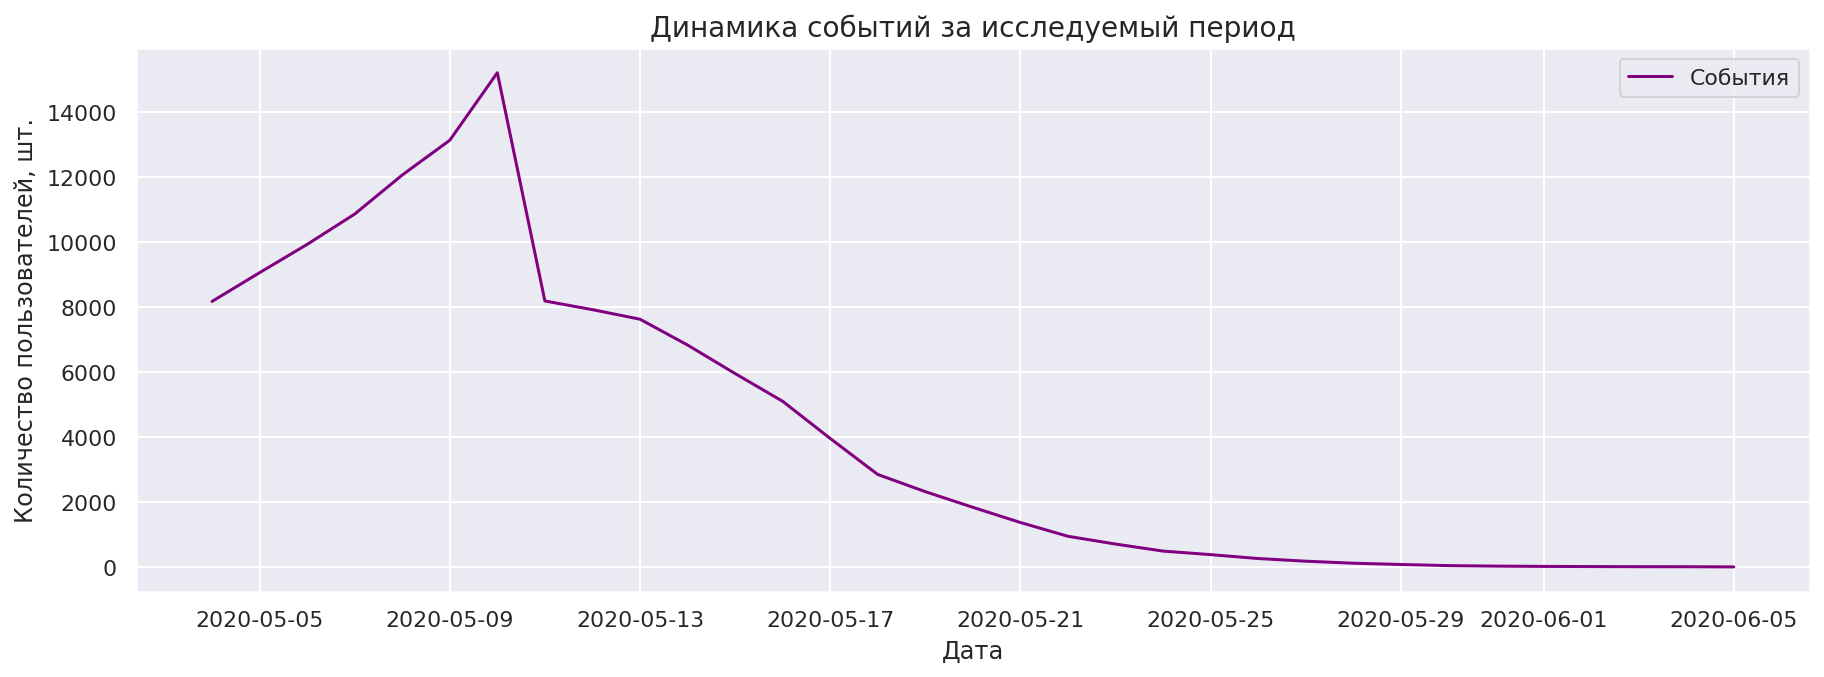

In [26]:
actions.groupby('day')['user_id'].count().plot(color='purple', label='События')
plt.title('Динамика событий за исследуемый период', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество пользователей, шт.')
plt.legend()
plt.show()

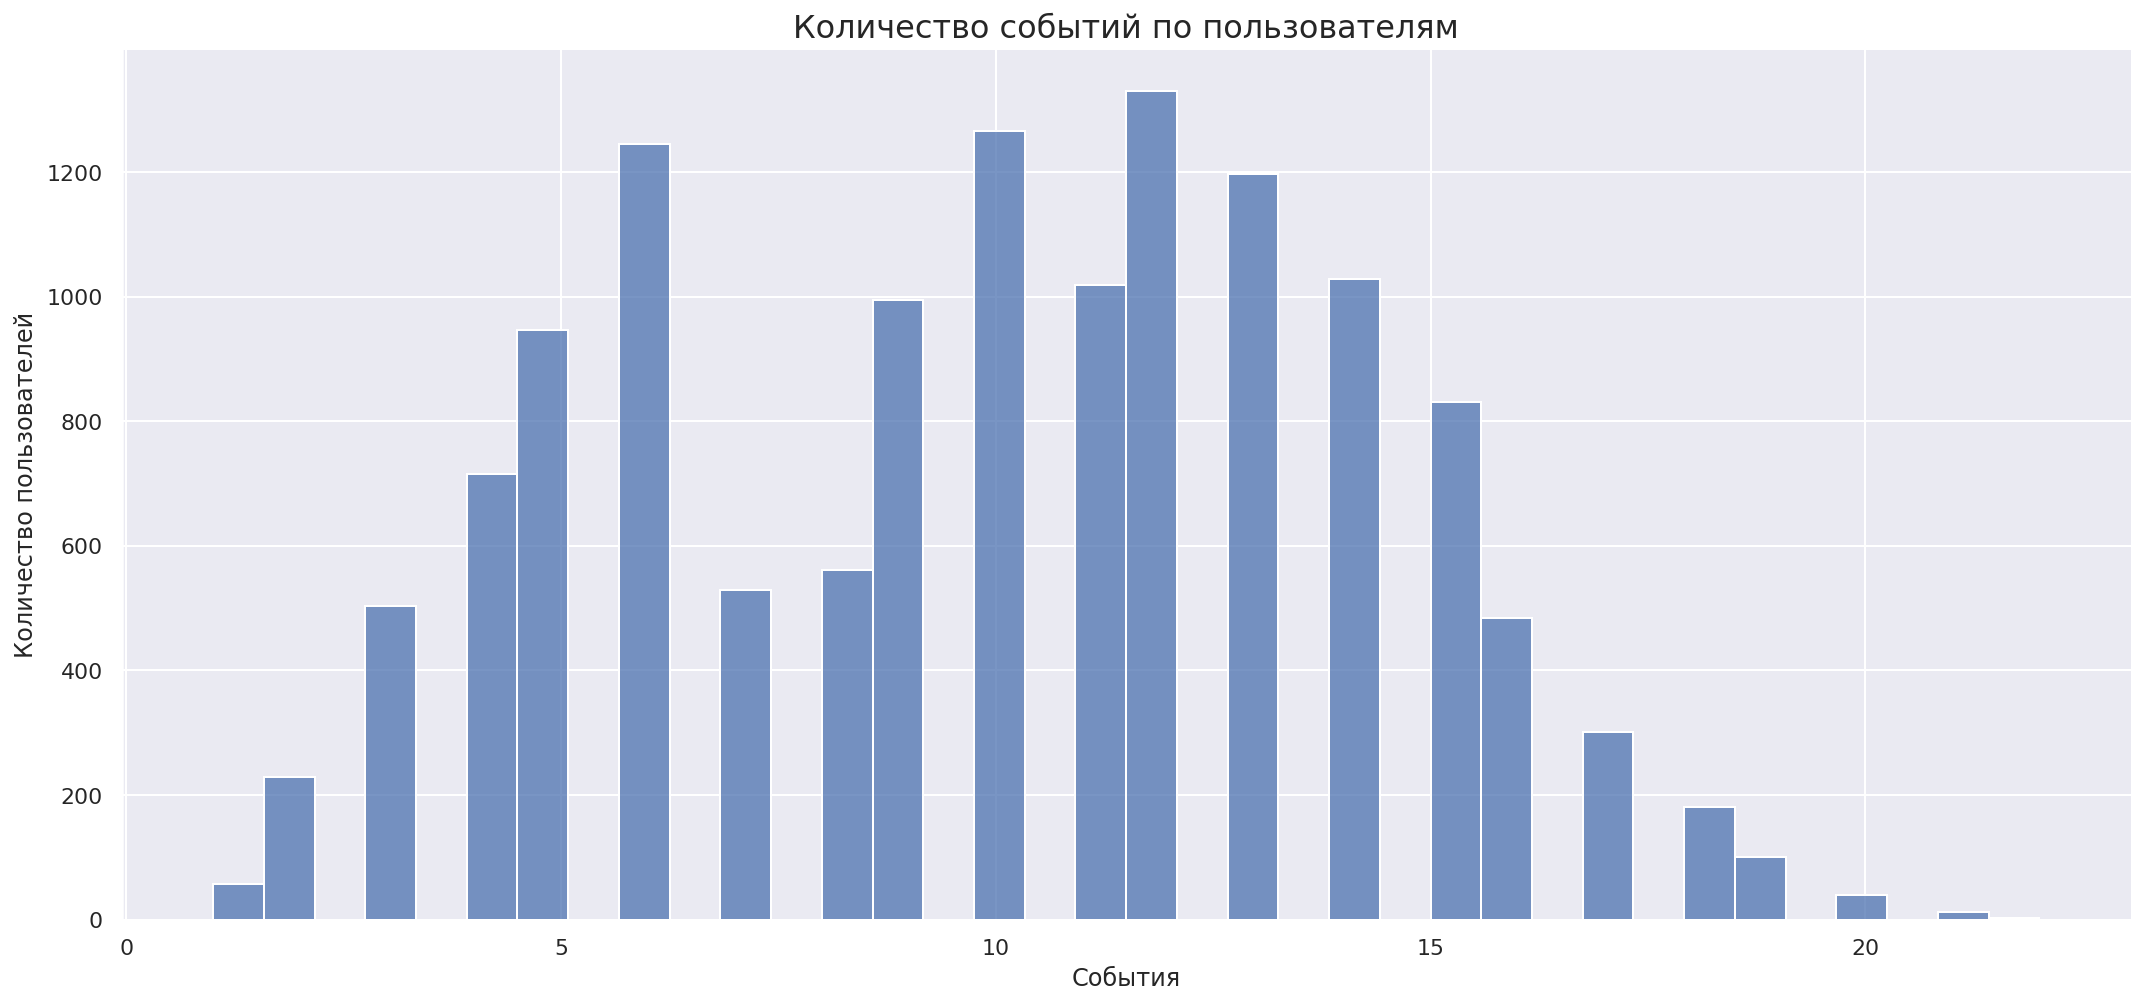

In [27]:
# график количества событий по пользователям
fig = plt.figure(figsize=(18,8))
ax = sns.histplot(median['event'])
ax.set_title('Количество событий по пользователям', fontsize=16)
ax.set_xlabel('События', fontsize=12)
ax.set_ylabel('Количество пользователей', fontsize=12)
sns.despine()
plt.show()

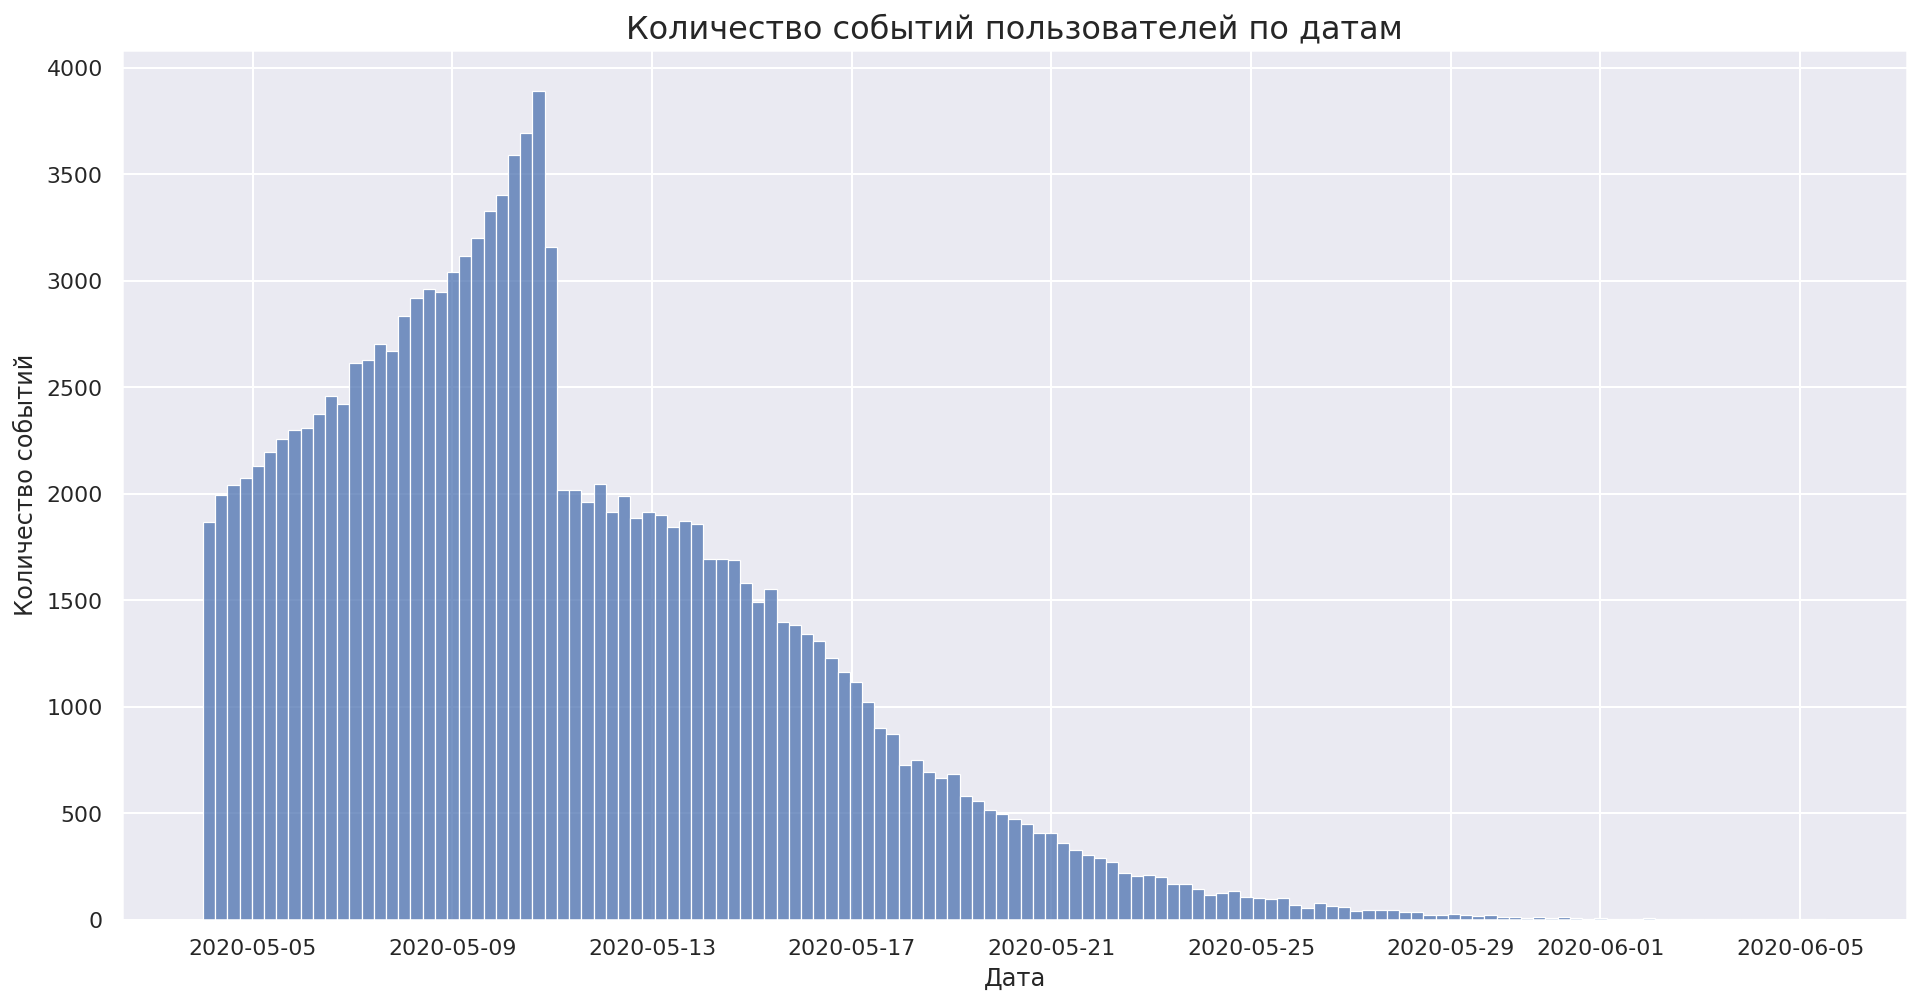

In [28]:
# график количества событий по датам
fig = plt.figure(figsize=(16,8))
ax = sns.histplot(actions['event_datetime'])
ax.set_title('Количество событий пользователей по датам', fontsize=16)
ax.set_xlabel('Дата', fontsize=12)
ax.set_ylabel('Количество событий', fontsize=12)
plt.show()

Исследуем количество уникальных событий в игре:

In [29]:
events_count = (
    actions.groupby('event')
    .agg({'user_id': 'count'})
    .reset_index()
    .sort_values(by = 'user_id', ascending = False)
)
events_count['%'] = (events_count['user_id'] / events_count['user_id'].sum()*100).round(2)
events_count

,event,user_id,%
0,building,127956,94.34
1,finished_stage_1,5817,4.29
2,project,1866,1.38


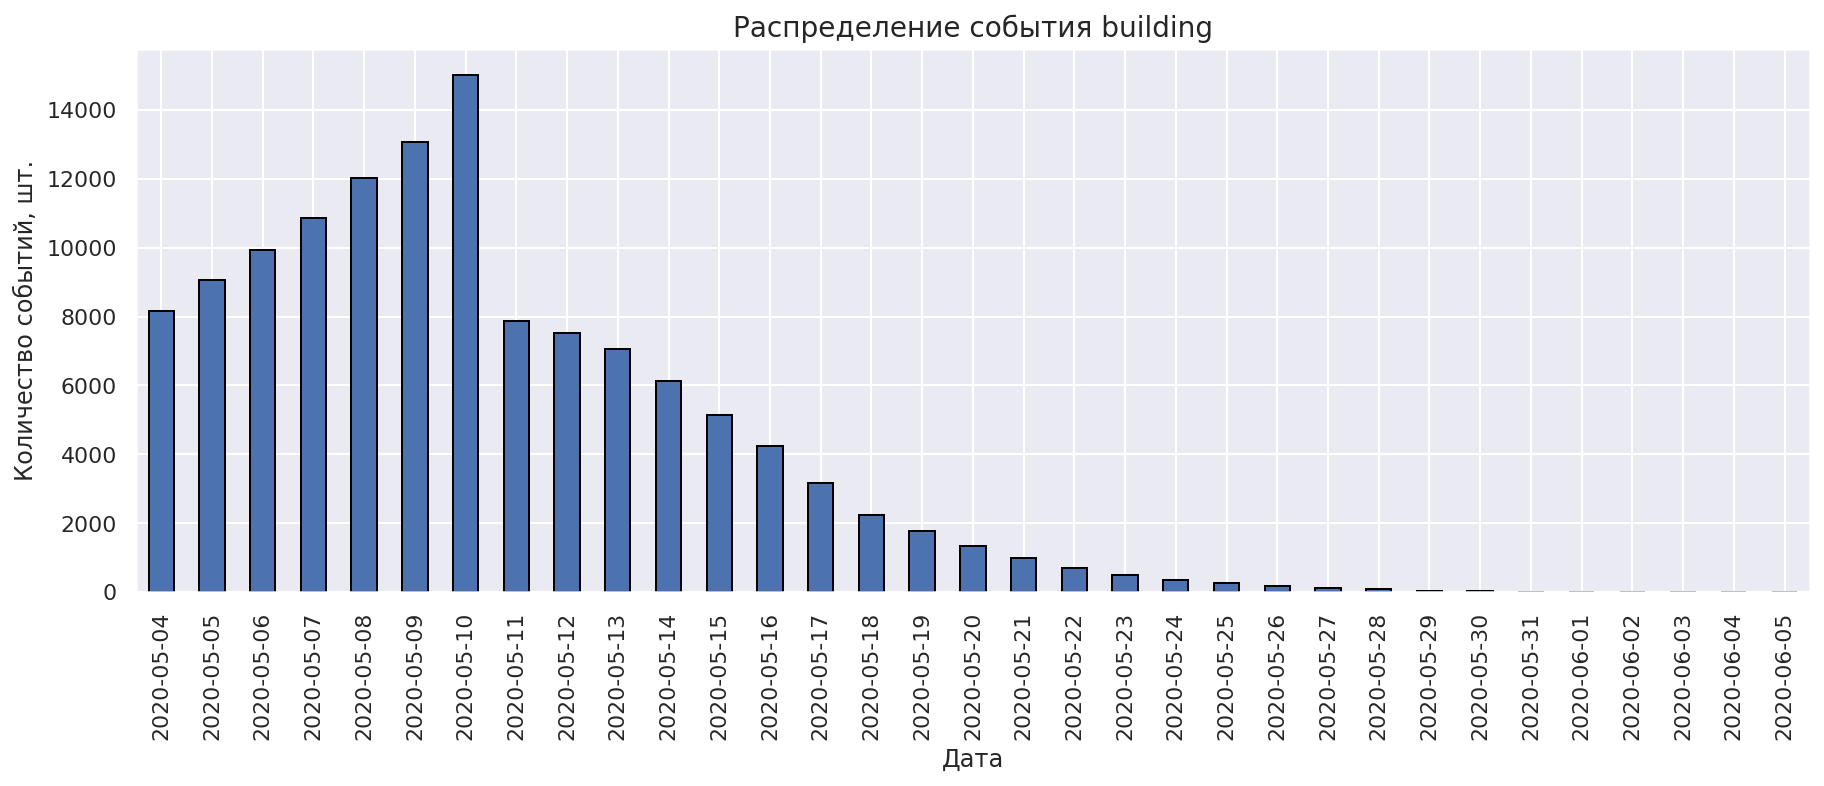

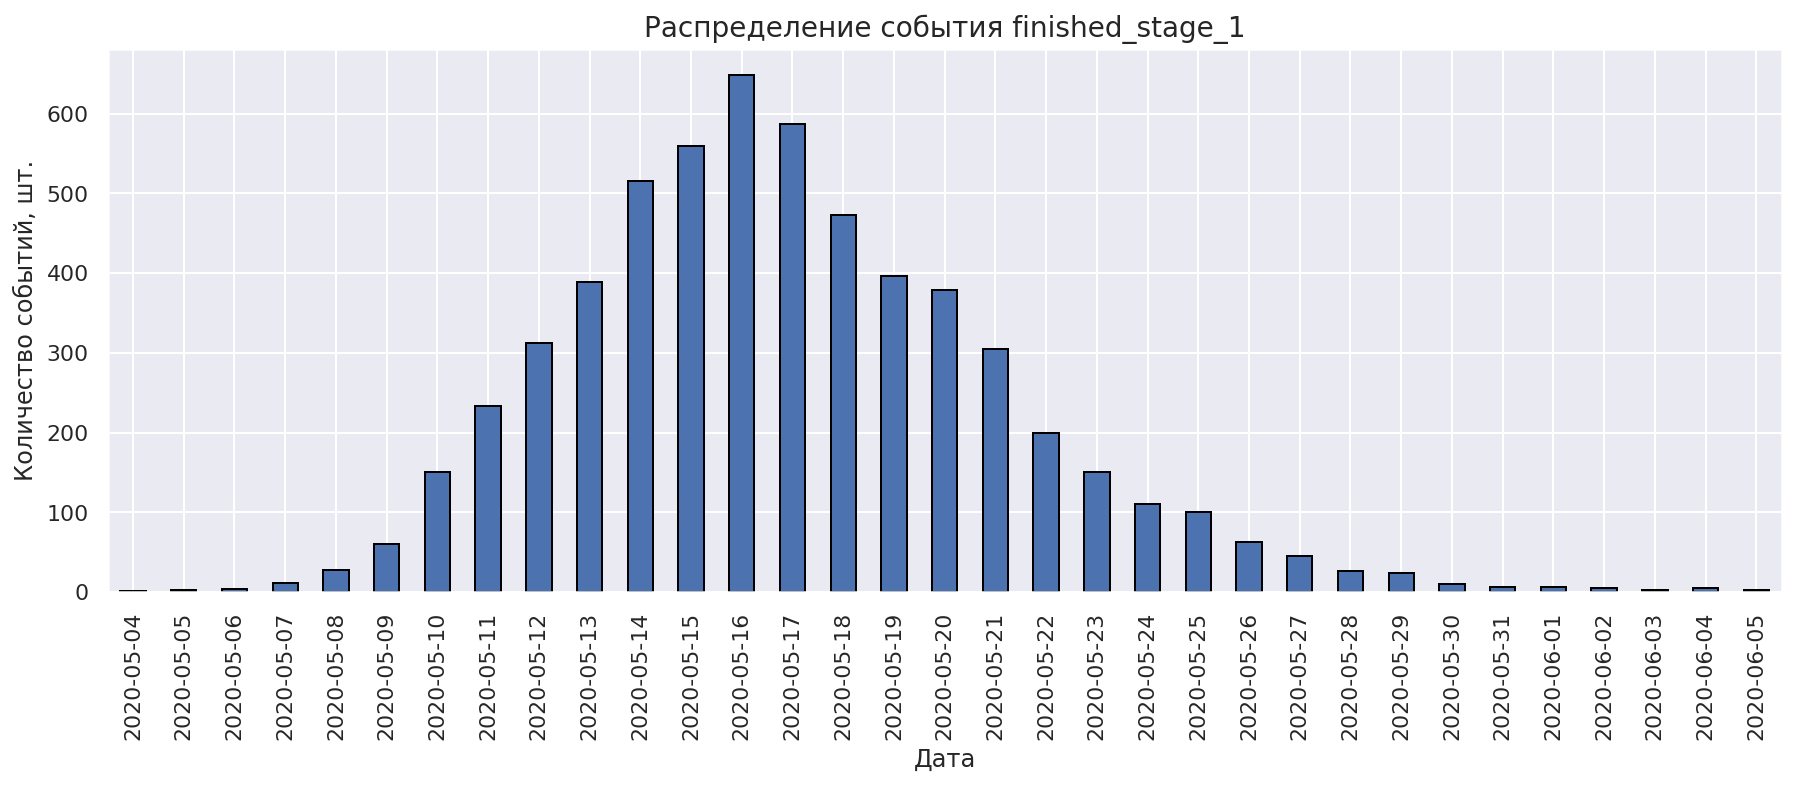

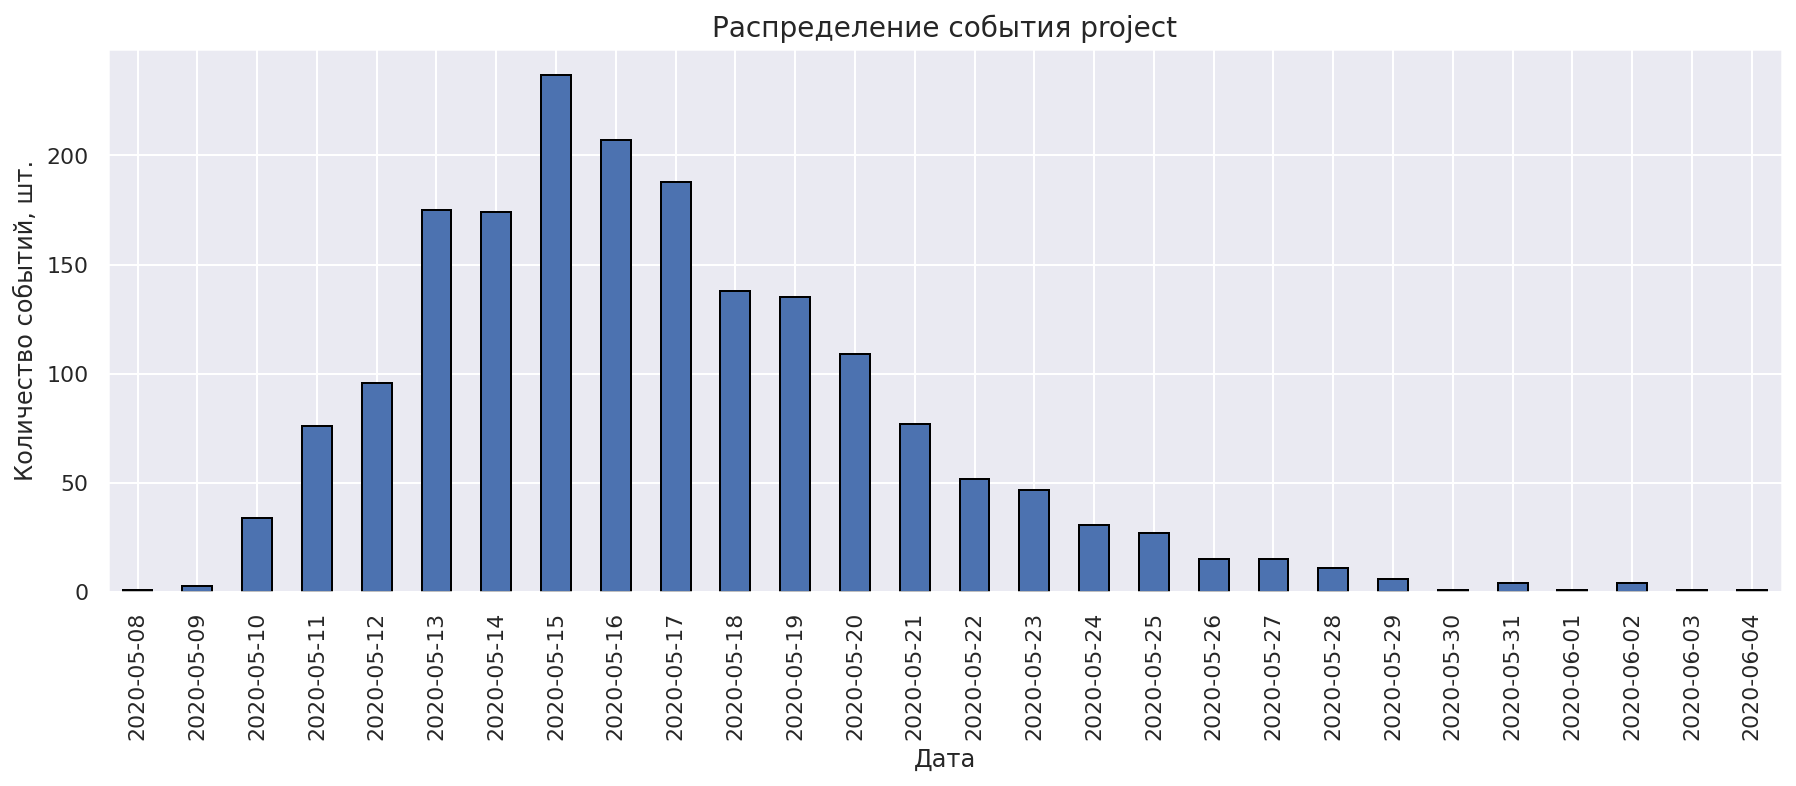

In [30]:
# Построим графики распределения событий по датам исследумого периода:
for i in actions['event'].unique():
    (actions[actions['event'] == i].groupby('day')['user_id'].count().
     plot(kind='bar', edgecolor='black'))
    plt.title('Распределение события {}'.format(i), fontsize=14)
    plt.xlabel('Дата')
    plt.ylabel('Количество событий, шт.')
    plt.show()

Больше всего событий типа "building" выполнено 10 мая, а 16 мая большинство игроков закончили первый уровень;

Самое популярное событие в игре building (около 94% всех событий в игре);

Реализация проекта занимает всего 1% всех событий в игре;

Большинство проектов было реализованно 15 мая 2020 года


In [31]:
# типы заданий в игре:
build_count = (
    actions.groupby('building_type')
    .agg({'user_id': 'count'})
    .reset_index()
    .sort_values(by = 'user_id', ascending = False)
)
build_count['%'] = (build_count['user_id'] / build_count['user_id'].sum()*100).round(2)
build_count

,building_type,user_id,%
2,spaceport,59325,46.36
0,assembly_shop,54494,42.59
1,research_center,14137,11.05


самая популярная постройка - spaceport - 46% из всех построенных зданий в игре, меньше всего построили research_centr - всего 11% от всех построек

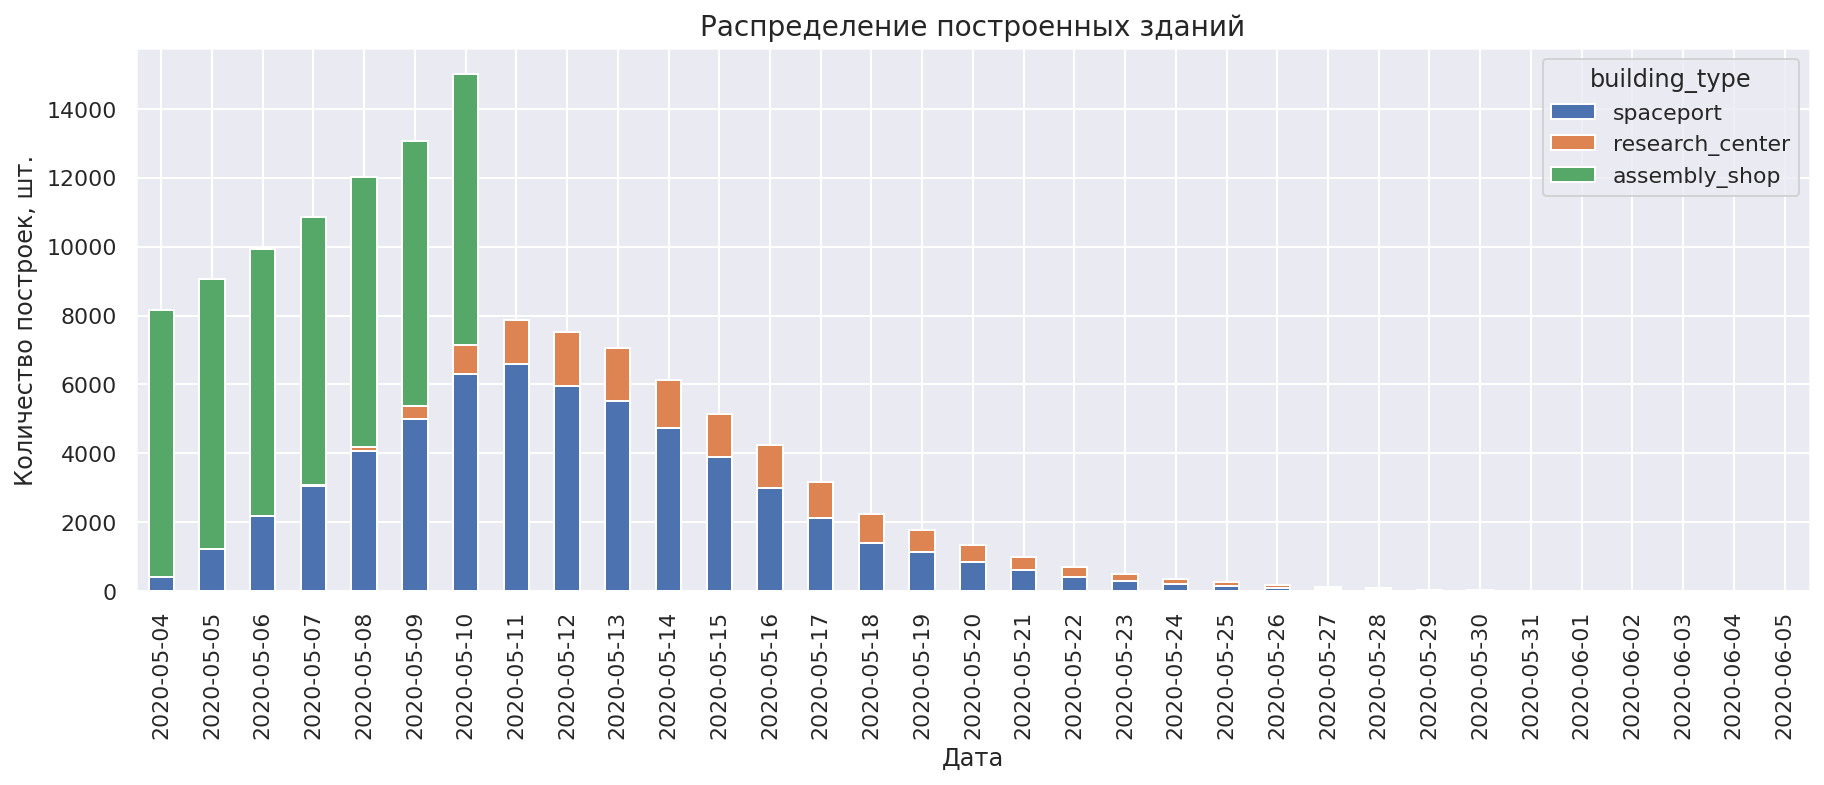

In [32]:
build_plot = (actions.groupby(['building_type', 'day']).size().reset_index().
           pivot(columns='building_type', index='day', values=0))
build_plot[['spaceport', 'research_center', 'assembly_shop']].plot(kind='bar', stacked=True)
plt.title('Распределение построенных зданий', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество построек, шт.')
plt.show()

Можно сделать следующие выводы:

    Самое популярное здание в игре spaceport (около 46% из всех построенных зданий в игре);
    Меньше всего построено researchcenter (всего 11% от всех построек);
    Здание assemblyshop строят только новые пользователи. Возможно, это самая первая постройка в игре;
    Больше всего зданий spaceport и researchcenter построено 11 мая 2020 года;
    Больше всего зданий assemblyshop построено 10 мая 2020 года (в последний день проведения рекламной компании).

Пользователи, завершившие уровень при помощи реализации проекта, а также победой над врагом

в дальнейшем я буду использовать сокращения:

    PVP - игрок закончил игру победой надо врагом
    PVE - игрок закончил игру выполнив проект

In [33]:
pvp = actions[actions['event'] == 'finished_stage_1']['event'].count() - actions['project_type'].count()
pvpp = pvp/users_count
pve = actions[actions['event'] == 'project']['event'].count()
pvep = pve/users_count
print('Количество пользователей, звершивших уровеньпобедой над первым врагом:', pvp)
print('Доля пользователей, рзавершивших {:.1%} от всех игроков'.format(pvpp))
print('Количество пользователей, звершивших уровень. реализовавших проект:', pve)
print('Доля пользователей, рзавершивших {:.1%} от всех игроков'.format(pvep))


Количество пользователей, звершивших уровеньпобедой над первым врагом: 3951
Доля пользователей, рзавершивших 29.1% от всех игроков
Количество пользователей, звершивших уровень. реализовавших проект: 1866
Доля пользователей, рзавершивших 13.7% от всех игроков


In [34]:
# таблица, отражающая количество пользователей стиль игры пользователей:
strategy_df = pd.DataFrame({
    'Не завершили уровень':[actions['user_id'].nunique() - 
                            actions[actions['event'] == 'finished_stage_1']['event'].count()],
    'Завершили уровень PVP':[actions[actions['event'] == 'finished_stage_1']['event'].count() - 
                                            actions['project_type'].count()],
    'Завершили уровень PVE':[actions['project_type'].count()]
}).T
strategy_df.columns = ['Количество пользователей, шт']
strategy_df['%'] = strategy_df['Количество пользователей, шт']/users_count*100
strategy_df

,"Количество пользователей, шт",%
Не завершили уровень,7759,57.15
Завершили уровень PVP,3951,29.10
Завершили уровень PVE,1866,13.74


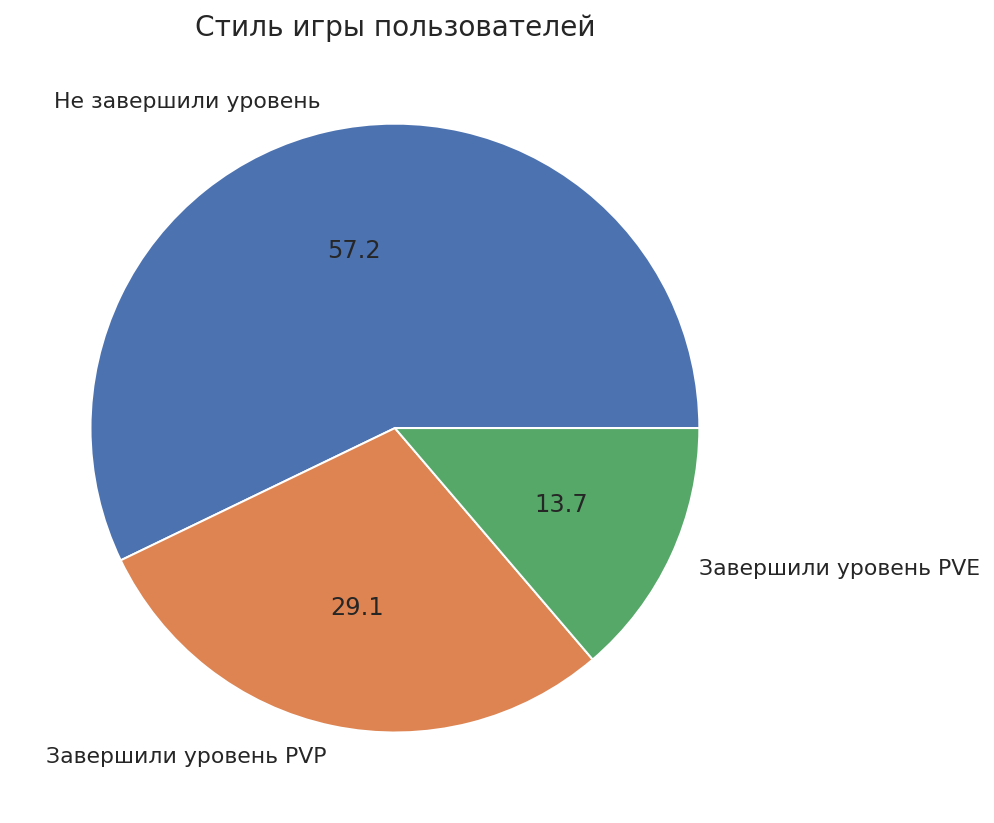

In [35]:
plt.figure(figsize=(20, 7))
plt.pie(x = strategy_df['Количество пользователей, шт'], 
        labels = strategy_df.index, 
        autopct="%.1f")
plt.title('Стиль игры пользователей', fontsize=14)
plt.show()

Всего первый уровень завершили 5817 (42.8%) игроков;

7759 (57.2%) пользователей покинули проект, не завершив игру;

1866 (13.7%) пользователей завершили уровень через реализацию проекта (PVE);

3951 (29.1%) пользователей завершили уровень победой над первым врагом (PVP).


In [36]:
# создам таблицу, отражающую количество и долю пользователей, пришедших из каждого рекламного источника:
user_source_count = (
    source.groupby('source')
    .agg({'user_id': 'count'})
    .sort_values(by = 'user_id', ascending=False)
    .reset_index()
)
user_source_count['%'] = user_source_count['user_id'] / users_count*100
user_source_count

,source,user_id,%
0,yandex_direct,4817,35.48
1,instagram_new_adverts,3347,24.65
2,facebook_ads,2726,20.08
3,youtube_channel_reklama,2686,19.78


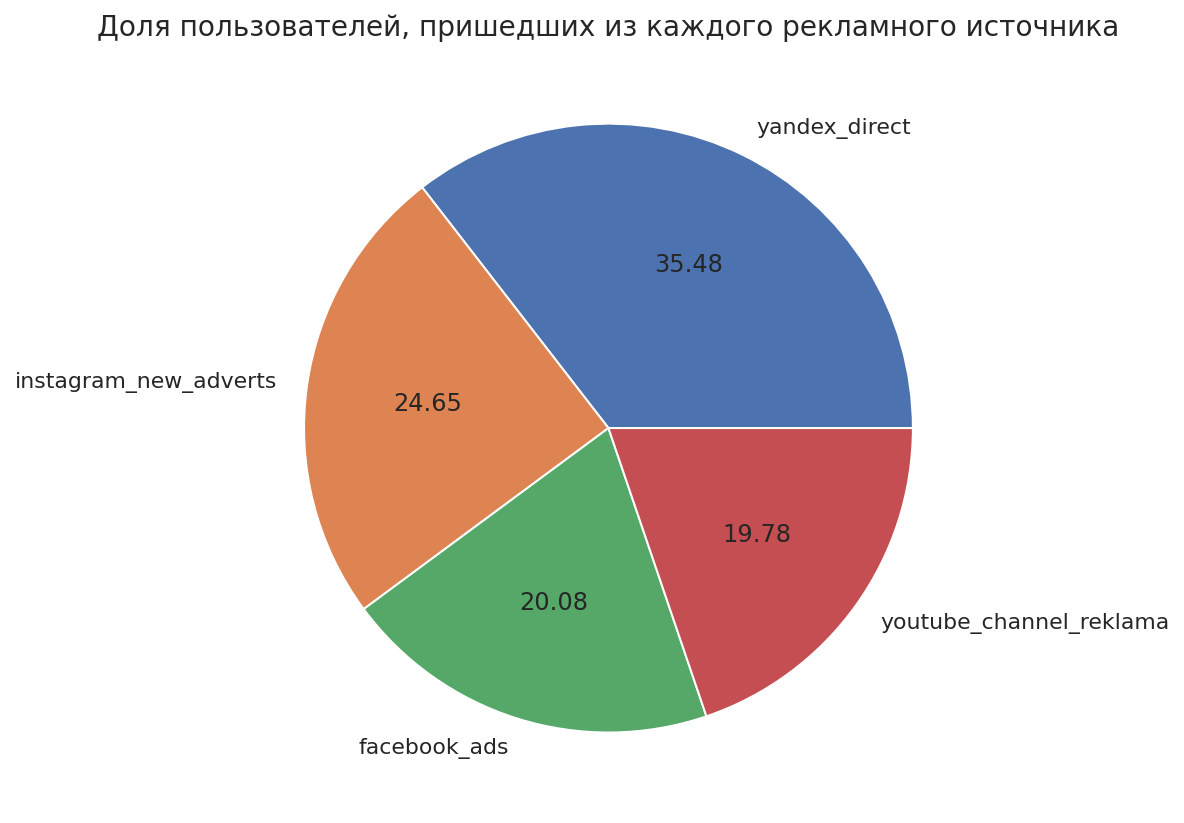

In [37]:
plt.figure(figsize=(20, 7))
plt.pie(x = user_source_count['user_id'], 
        labels = user_source_count['source'], 
        autopct="%.2f")
plt.title('Доля пользователей, пришедших из каждого рекламного источника', fontsize=14)
plt.show()

Самый популярный рекламный источник - Yandex.Direct, именно через него в игру пришло 4817 (35.48%) пользователей;

Наименее популярные источники: Facebook (20.08% пользователей) и Youtube (19.78% пользователей).

In [38]:
# общая сумма расходов на рекламные источники:
print('Общая сумма расходов на рекламные источники за исследуемый период:', round(costs.cost.sum()), 'у.е.')

Общая сумма расходов на рекламные источники за исследуемый период: 7604 у.е.


In [39]:
# распределение рекламных затрат в разрезе по дням:
ad_costs_sum = (
     costs.groupby('day')
    .agg({'cost': 'sum'})
    .rename(columns = ({'cost': 'sum'}))
    .sort_values(by = 'sum', ascending=False)
    .reset_index()
)
ad_costs_sum['%'] = ad_costs_sum['sum'] / ad_costs_sum['sum'].sum()*100
ad_costs_sum

,day,sum,%
0,2020-05-04,3302.45,43.43
1,2020-05-05,1865.00,24.53
2,2020-05-06,1029.43,13.54
3,2020-05-07,620.48,8.16
4,2020-05-08,391.85,5.15
5,2020-05-09,242.77,3.19
6,2020-05-10,151.59,1.99


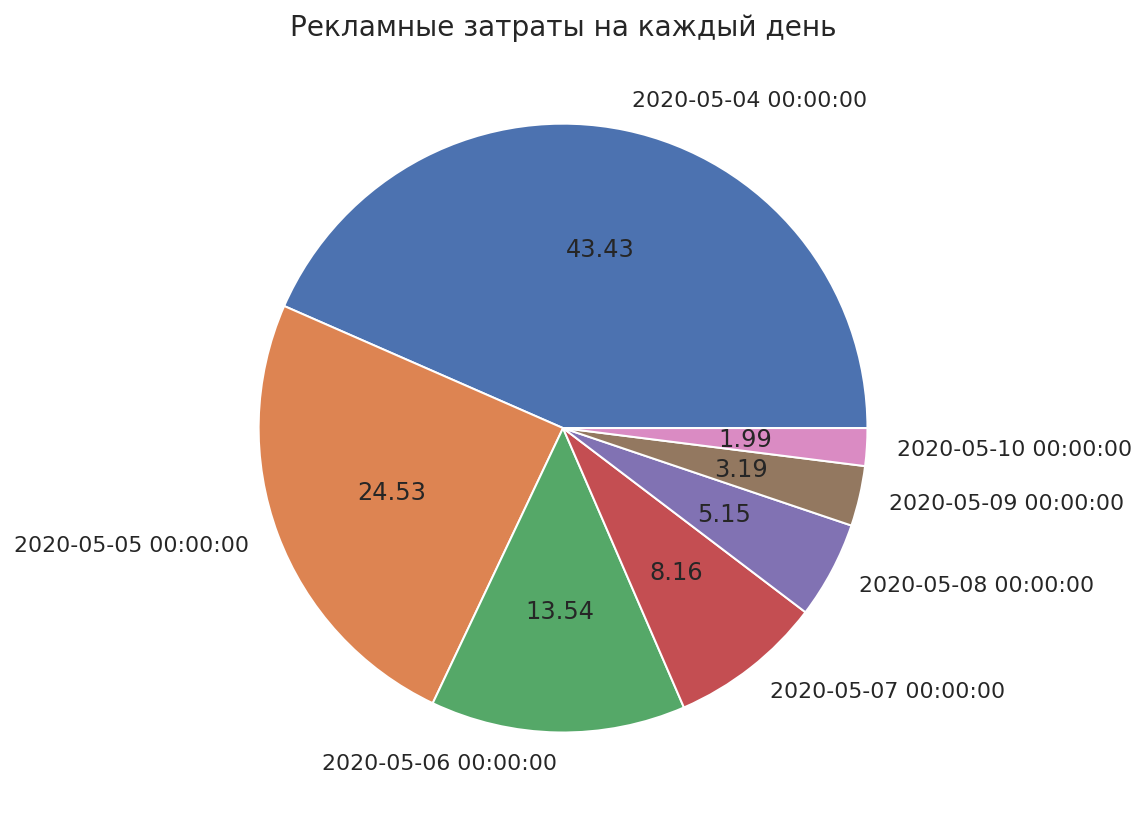

In [40]:
plt.figure(figsize=(20, 7))
plt.pie(x = ad_costs_sum['sum'], 
        labels = ad_costs_sum['day'], 
        autopct="%.2f")
plt.title('Рекламные затраты на каждый день', fontsize=14)
plt.show()

Всего за период проведения рекламной компании было затрачено 7604 у.е.;

43% всех рекламных затрат произведено 3 мая 2020 года (в первый день рекламной компании);

В течении проведения рекламной компании наблюдается равномерное падение затрат;

В последний день проведения рекламной компании (9 мая 2020 года) затраты минимальны (2% от общих).

In [41]:
# распределение рекламных затрат в разрезе по источникам:
total_costs = (
     costs.groupby('source')
    .agg({'cost': 'sum'})
    .rename(columns = ({'cost': 'sum'}))
    .sort_values(by = 'sum', ascending=False)
    .reset_index()
)
total_costs['%'] = total_costs['sum'] / total_costs['sum'].sum()*100
total_costs

,source,sum,%
0,yandex_direct,2233.11,29.37
1,instagram_new_adverts,2161.44,28.43
2,facebook_ads,2140.90,28.16
3,youtube_channel_reklama,1068.12,14.05


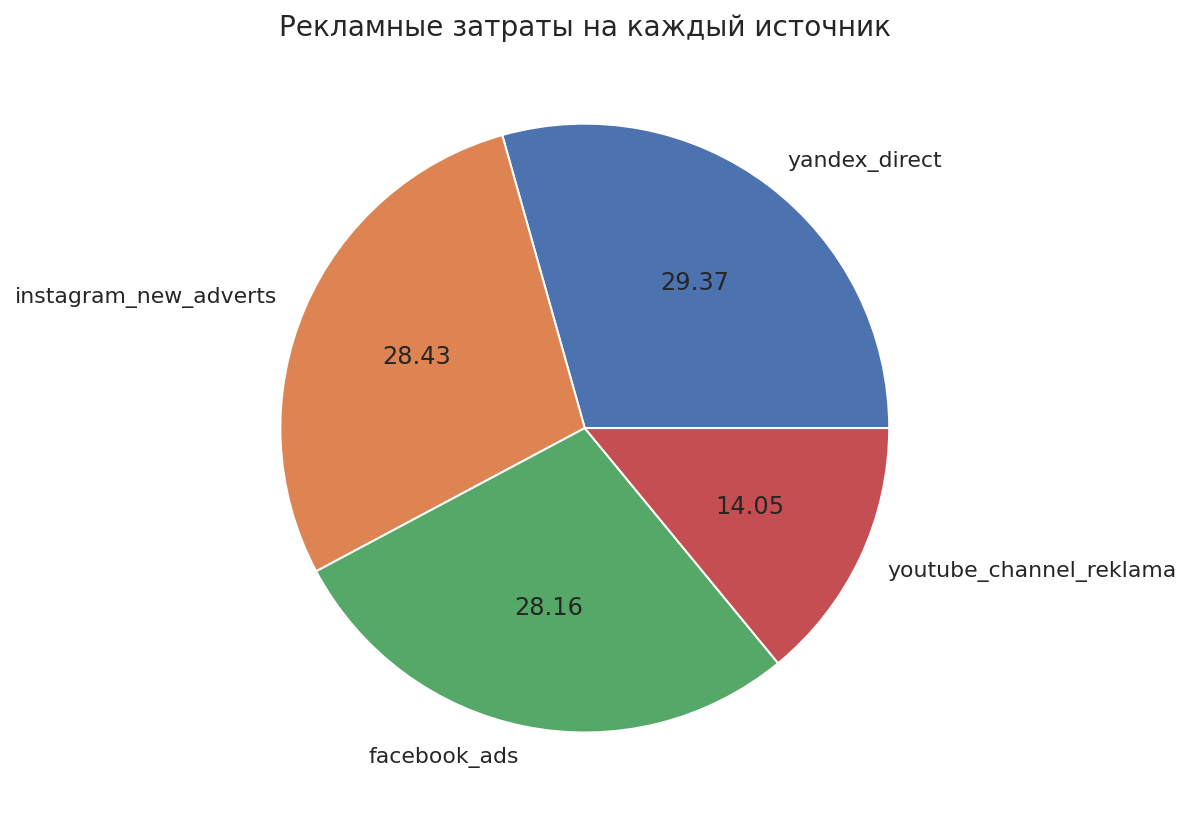

In [42]:
plt.figure(figsize=(20, 7))
plt.pie(x = total_costs['sum'], 
        labels = total_costs['source'], 
        autopct="%.2f")
plt.title('Рекламные затраты на каждый источник', fontsize=14)
plt.show()

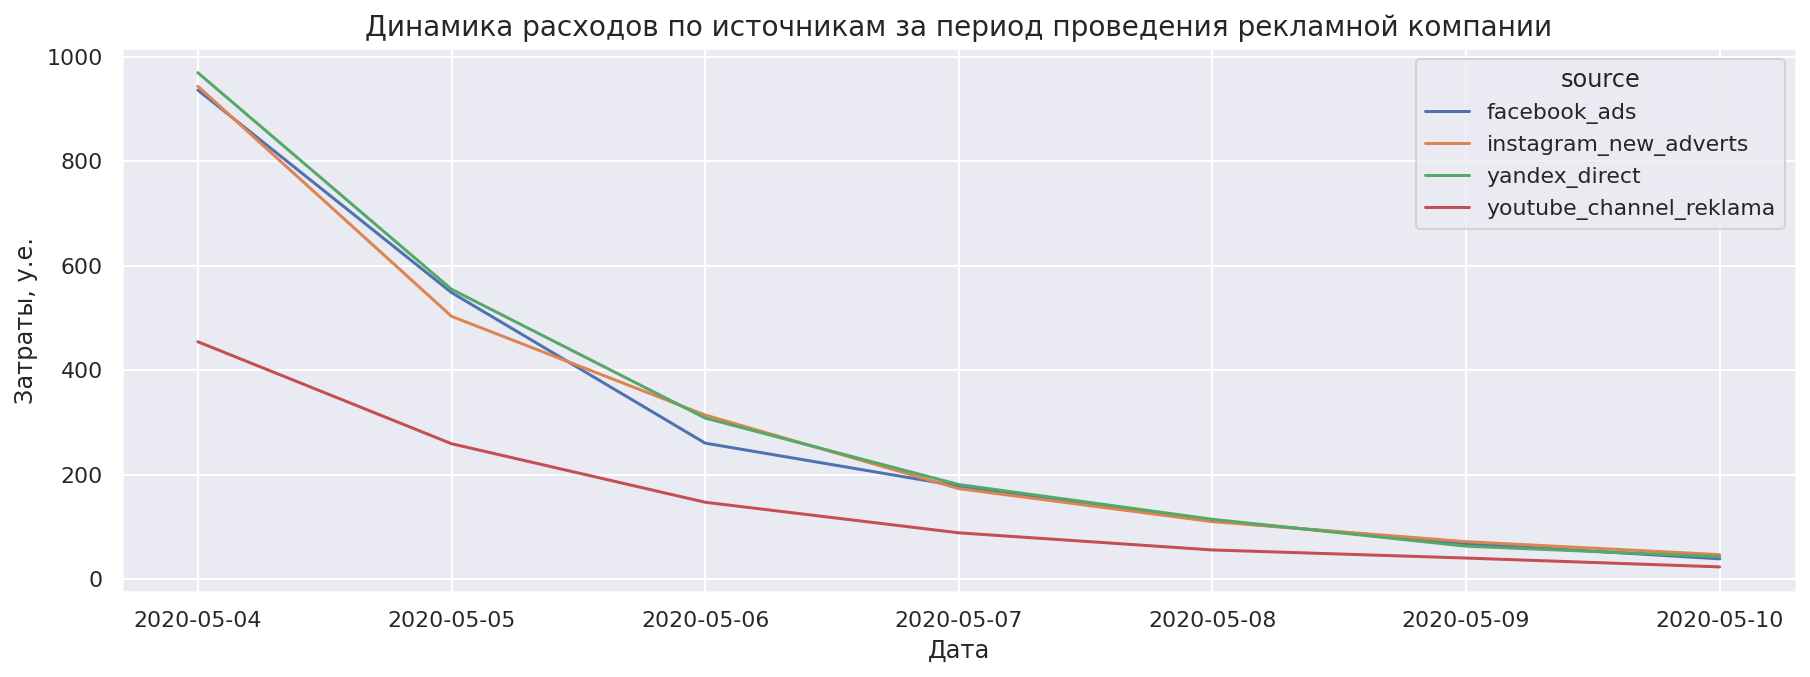

In [43]:
# график, отражающий динамику расходов по источникам за период проведения рекламной компании:
sns.lineplot(data = costs, x='day', y='cost', hue='source')
plt.title('Динамика расходов по источникам за период проведения рекламной компании', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Затраты, у.е.')
plt.show()

Самое большое количество затрат (29.37%) ушло на рекламный источник Yandex.Direct;

Наименьшие затраты (14.05%) на рекламный источник Youtube;

В течении рекламной компании затраты на все источники равномерно снижаются.


### Вывод
    Пользователей в игре: 13576
    Количество событий: 135639 событий
    Пик совершенных событий приходится на 10 мая 2020 года (15207 событий);
    Пик пользователей приходится на 10 мая 2020 года (9219 человек);
    После 10 мая 2020 года активность пользователей в игре стремительно снижается.
    Самое популярное событие в игре building (около 94% всех событий в игре);
    Реализация проекта занимает всего 1% всех событий в игре;
    Больше всего событий, косающихся завершения 1 уровня, приходится на 16 мая 2020 года;
    Самое популярное здание в игре spaceport (около 46% из всех построенных зданий в игре);
    Всего первый уровень завершили 5817 (42.8%) игроков;
    1866 (13.7%) пользователей завершили уровень через реализацию проекта;
    3951 (29.1%) пользователей завершили уровень победой над первым врагом;
    Самый популярный рекламный источник - Yandex.Direct, именно через него в игру пришло 4817 (35.48%) пользователей;
    Наименее популярные источники: Facebook (20.08% пользователей) и Youtube (19.78% пользователей);
    Всего за период проведения рекламной компании было затрачено 7604 у.е.;
    43% всех рекламных затрат произведено 3 мая 2020 года (в первый день рекламной компании);
    Самое большое количество затрат (29.37%) ушло на рекламный источник Yandex.Direct;
    Наименьшие затраты (14.05%) на рекламный источник Youtube;
    В течении рекламной компании затраты на все источники равномерно снижаются;
    Среднее количество событий на пользователя: 10.0
    Медианное количество событий на пользователя: 10.0

## Влияние источника на пользовательские паттерны

In [44]:
actions = actions.merge(
    source[['user_id', 'source']], on='user_id', how='left')

In [45]:
# Анализ динамики пользователей в разрезе источников
# количество пользователей по дням в разрезе источников перехода:
user_by_source = (actions.
                  pivot_table(index='day', columns='source', values='user_id', aggfunc='nunique'))
user_by_source

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
day,,,,
2020-05-04,1184.00,1452.00,2078.00,1146.00
2020-05-05,1328.00,1539.00,2291.00,1224.00
2020-05-06,1389.00,1670.00,2445.00,1350.00
2020-05-07,1535.00,1802.00,2613.00,1434.00
2020-05-08,1583.00,1962.00,2784.00,1562.00
2020-05-09,1700.00,2077.00,2958.00,1659.00
2020-05-10,1860.00,2301.00,3271.00,1787.00
2020-05-11,1278.00,1432.00,2163.00,1122.00
2020-05-12,1153.00,1457.00,2030.00,1136.00


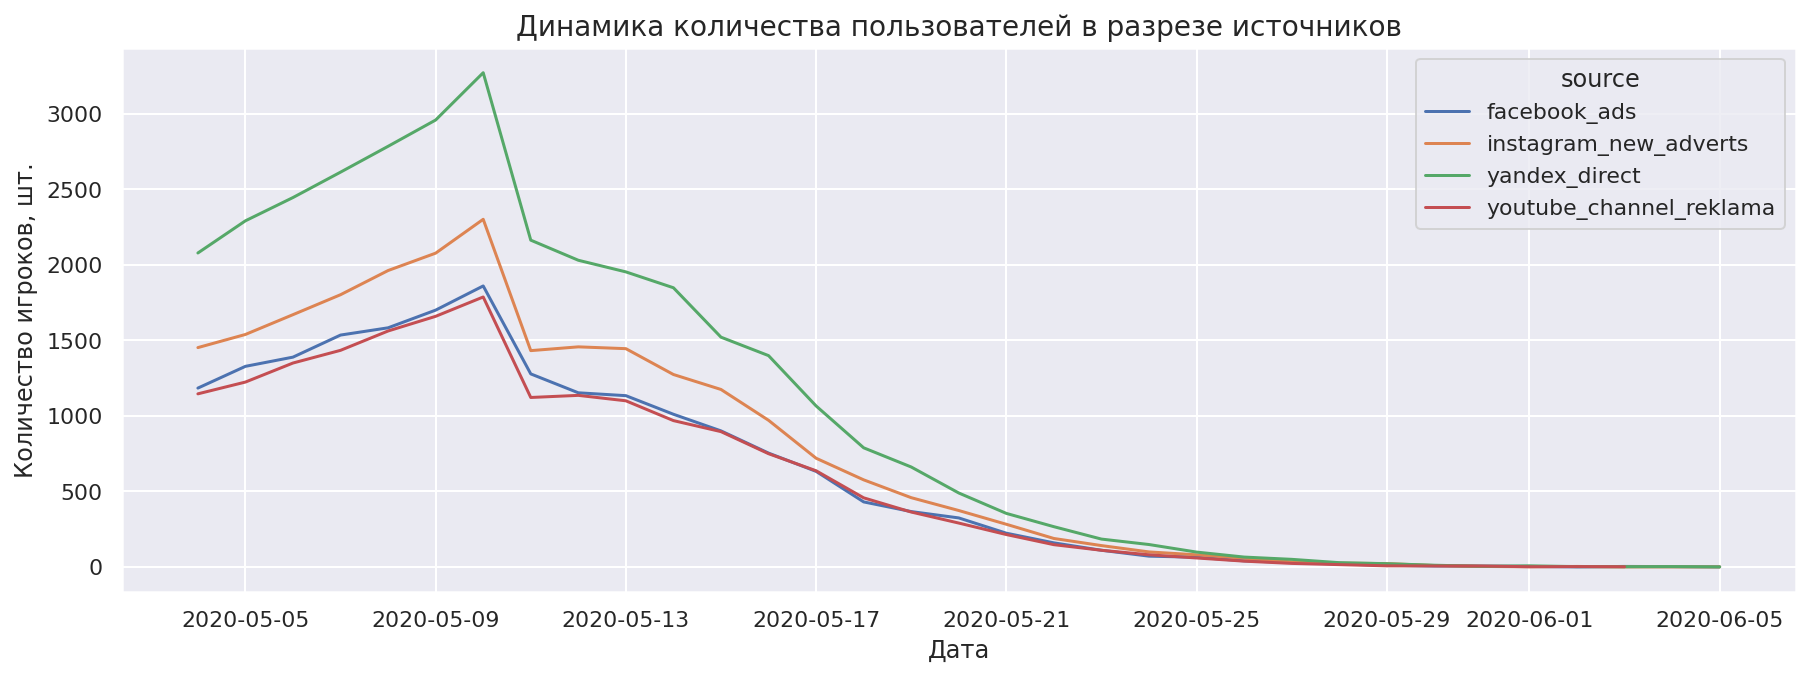

In [46]:
# график, отражающий динамику пользователей за исследуемый период в разрезе истоников перехода в игру:
user_by_source.plot(figsize=(15,5))
plt.title('Динамика количества пользователей в разрезе источников', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество игроков, шт.')
plt.show()

Пик пользователей, перешедших в игру из каждого источника наблюдается 10 мая 2020 года;

После окончания рекламной компании происходит спад пользователей.

In [47]:
# события в разрезе по источникам
user_event_source = actions.pivot_table(
    index = 'source',
    columns = 'event',
    values = 'user_id',
    aggfunc = 'count'
)
user_event_source.sort_values(by = 'building', ascending = False).reset_index()

event,source,building,finished_stage_1,project
0,yandex_direct,45032,2042,620
1,instagram_new_adverts,31815,1466,476
2,facebook_ads,26131,1150,391
3,youtube_channel_reklama,24978,1159,379


Максимальное количество пользователей, завершивших первый уровень (2042 пользователя), пришло через рекламный источник Yandex.Direct;

Максимальное количество пользователей, завершивших первый уровень реализацией проекта (620 пользователей), пришло через рекламный источник Yandex.Direct.

In [48]:
# Анализ построек в разрезе по источникам
user_building_source = actions.pivot_table(
    index = 'source',
    columns = 'building_type',
    values = 'user_id',
    aggfunc = 'count'
)
user_building_source.sort_values(by = 'assembly_shop', ascending = False).reset_index()

building_type,source,assembly_shop,research_center,spaceport
0,yandex_direct,19295,4952,20785
1,instagram_new_adverts,13431,3537,14847
2,facebook_ads,11117,2945,12069
3,youtube_channel_reklama,10651,2703,11624


Большинство всех построк построено игроками пришедшими из канала яндекс.директ

In [49]:
#временя, проведенноe в игре, от источника перехода
# среднее количество дней, проведенное пользователями
user_source_days_in_game = source.pivot_table(
    index = 'source',
    values = 'days_in_game',
    aggfunc = 'mean'
)
user_source_days_in_game.sort_values(by = 'days_in_game', ascending = False).reset_index()

,source,days_in_game
0,instagram_new_adverts,11.75
1,facebook_ads,11.68
2,yandex_direct,11.57
3,youtube_channel_reklama,11.55


В среднем пользователи, пришедшие из разных рекламных истоников, проводят в игре около 11-12 дней;

Время, проведенное пользователями в игре, не зависит от источника перехода;

In [50]:
# среднее количество дней, необходимое пользователям, пришедшим из разных истоников, на завершение 1 уровня:
user_source_finish_level = source.pivot_table(
    index = 'source',
    values = 'days_to_finished_stage_1',
    aggfunc = 'mean'
)
user_source_finish_level.sort_values(by = 'days_to_finished_stage_1', ascending = False).reset_index()

,source,days_to_finished_stage_1
0,youtube_channel_reklama,12.86
1,instagram_new_adverts,12.85
2,facebook_ads,12.79
3,yandex_direct,12.76


В среднем пользователям, пришедшим из разных рекламных истоников, требуется около 12-13 дней на завершение 1 уровня;

Время, затраченное на завершение 1 уровня, не зависит от источника перехода;

### Вывод:
    Пик пользователей в разрезе источников наблюдается 10 мая 2020 года, после чего наблюдается спад;
    Больше всего зданий (45032 события) построено пользователями, пришедшими через рекламный источник Yandex.Direct;
    Максимальное количество пользователей, завершивших первый уровень (2042 пользователя), пришло через рекламный источник Yandex.Direct;
    Максимальное количество пользователей, завершивших первый уровень реализацией проекта (620 пользователей), пришло через рекламный источник Yandex.Direct;
    Больше всего зданий различного типа построено пользователями, пришедшими через рекламный источник Yandex.Direct;
    В среднем пользователи проводят в игре около 11-12 дней, независимо от источника перехода;
    В среднем пользователям требуется около 12-13 дней на завершение 1 уровня, независимо от источника перехода;

## Игровая стратегия

In [51]:
actions['action'] = (actions['building_type']
                         .fillna(actions['project_type'])
                         .fillna(actions['event']))
actions.head()

,event_datetime,event,building_type,user_id,project_type,day,time,source,action
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,00:00:01,youtube_channel_reklama,assembly_shop
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,00:00:03,facebook_ads,assembly_shop
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,00:00:16,instagram_new_adverts,assembly_shop
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,00:00:16,facebook_ads,assembly_shop
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,00:00:35,yandex_direct,assembly_shop


In [52]:
# таблица, отражающая последовательность действий, совершенных каждым пользователем за время пребывания в игре:
actions['action'] = (actions['building_type']
                         .fillna(actions['project_type'])
                         .fillna(actions['event']))
users_actions = (actions.groupby('user_id')['action'].
             apply(lambda event: ', '.join(event.values)).reset_index(name='strategy'))
users_actions.head()

,user_id,strategy
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,"assembly_shop, assembly_shop, assembly_shop, assembly_shop, assembly_shop, assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, spaceport, research_center"
1,00151b4f-ba38-44a8-a650-d7cf130a0105,"assembly_shop, assembly_shop, assembly_shop, assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport"
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,"assembly_shop, assembly_shop, spaceport, spaceport"
3,001d39dc-366c-4021-9604-6a3b9ff01e25,"assembly_shop, assembly_shop, assembly_shop, spaceport, spaceport, assembly_shop, spaceport, spaceport, finished_stage_1"
4,002f508f-67b6-479f-814b-b05f00d4e995,"assembly_shop, spaceport, assembly_shop, assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, research_center, spaceport, spaceport"


In [53]:
source = source.merge(users_actions, how='outer', on=['user_id',])

In [54]:
# популярные стратегии
top_strategy = (source.groupby(['strategy', 'source']).
             agg({'user_id':'count', 'days_in_game':'mean'}).
             reset_index().sort_values(by='user_id', ascending=False))
top_strategy.head(10)

,strategy,source,user_id,days_in_game
7199,"assembly_shop, spaceport, spaceport",yandex_direct,76,6.58
4487,"assembly_shop, assembly_shop, spaceport",yandex_direct,71,6.03
7514,"assembly_shop, spaceport, spaceport, spaceport, spaceport",yandex_direct,66,10.03
6230,"assembly_shop, spaceport",yandex_direct,65,4.37
7452,"assembly_shop, spaceport, spaceport, spaceport",yandex_direct,63,8.92
7546,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport",yandex_direct,63,11.16
5917,"assembly_shop, assembly_shop, spaceport, spaceport, spaceport, spaceport",yandex_direct,59,10.58
5577,"assembly_shop, assembly_shop, spaceport, spaceport",yandex_direct,57,8.86
7200,"assembly_shop, spaceport, spaceport",youtube_channel_reklama,54,7.17
2963,"assembly_shop, assembly_shop, assembly_shop, spaceport",yandex_direct,53,7.53


In [55]:
#стратегии, завершивние уровень PVP
top_strategy[top_strategy['strategy'].str.contains('finished_stage_1')].head()

,strategy,source,user_id,days_in_game
7554,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, finished_stage_1",yandex_direct,23,11.87
7542,"assembly_shop, spaceport, spaceport, spaceport, spaceport, finished_stage_1",yandex_direct,21,12.19
5573,"assembly_shop, assembly_shop, spaceport, finished_stage_1",yandex_direct,20,6.15
7510,"assembly_shop, spaceport, spaceport, spaceport, finished_stage_1",yandex_direct,18,9.89
7447,"assembly_shop, spaceport, spaceport, finished_stage_1",instagram_new_adverts,18,6.83


In [56]:
#стратегии, завершивние уровень PVE
top_strategy[top_strategy['strategy'].str.contains('satellite_orbital_assembly')].head()

,strategy,source,user_id,days_in_game
6168,"assembly_shop, assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, spaceport, spaceport, research_center, satellite_orbital_assembly, finished_stage_1",youtube_channel_reklama,5,14.80
230,"assembly_shop, assembly_shop, assembly_shop, assembly_shop, assembly_shop, assembly_shop, assembly_shop, spaceport, spaceport, research_center, satellite_orbital_assembly, finished_stage_1",yandex_direct,5,14.20
7708,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, spaceport, spaceport, research_center, research_center, satellite_orbital_assembly, finished_stage_1",youtube_channel_reklama,4,18.00
6167,"assembly_shop, assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, spaceport, spaceport, research_center, satellite_orbital_assembly, finished_stage_1",yandex_direct,4,17.00
786,"assembly_shop, assembly_shop, assembly_shop, assembly_shop, assembly_shop, assembly_shop, spaceport, spaceport, research_center, spaceport, satellite_orbital_assembly, finished_stage_1",yandex_direct,3,13.67


### Вывод
    В среднем пользователи проводят в игре около 11-12 дней, независимо от источника перехода;
    В среднем пользователям требуется около 12-13 дней на завершение 1 уровня;
    Количество построек влияет на время нахождения в игре (большек построек - больше проведенного в игре времени);

## Когортный анализ

Расчёт Retention Rate

Retention Rate, или коэффициент удержания, показывает, как долго клиенты остаются с компанией. Это один из важнейших показателей «здоровья» бизнеса.

In [57]:
# подсчет первого и последнего вхождения игроков в игру
l1 = (actions.groupby('user_id')
           .agg({'event_datetime': 'min'})
           .rename(columns = {'event_datetime':'first_time',})  
           .reset_index())
l2 = (actions.groupby('user_id')
           .agg({'event_datetime':'max'})
           .rename(columns = {'event_datetime':'last_time',})
           .reset_index())
lifetime = l1.merge(l2, how='outer', on=['user_id',])
lifetime

,user_id,first_time,last_time
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45
...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,2020-05-04 01:58:59,2020-05-11 22:15:54
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,2020-05-04 11:58:14,2020-05-14 10:11:36
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,2020-05-04 02:05:09,2020-05-12 13:01:52
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,2020-05-04 20:28:28,2020-05-11 22:04:30


In [58]:
source_s

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts


In [59]:
# вычисляем лайфтайм для каждой сессии в днях

lifetime['lifetime'] = (
    lifetime['last_time'] - lifetime['first_time']
).dt.days
lifetime['day'] = lifetime['first_time'].dt.date
lifetime = lifetime.merge(source_s, how='outer', on=['user_id',])
                         
lifetime.head(5).sort_values(by = 'lifetime',ascending = False)

,user_id,first_time,last_time,lifetime,day,source
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,16,2020-05-05,facebook_ads
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,14,2020-05-06,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,12,2020-05-06,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,8,2020-05-05,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,6,2020-05-05,instagram_new_adverts


In [60]:
print('В среднем игроки играют дней:',lifetime['lifetime'].mean())
print('медианное количество дней:', lifetime['lifetime'].median())

В среднем игроки играют дней: 10.175309369475546
медианное количество дней: 10.0


In [61]:
source_grouped = (lifetime.groupby('source')
                  .agg({'user_id':'count'})
                  .rename(columns = ({'user_id': 'count_users'}))
                  .sort_values(by = 'count_users', ascending = False)
                  .reset_index())
source_grouped

,source,count_users
0,yandex_direct,4817
1,instagram_new_adverts,3347
2,facebook_ads,2726
3,youtube_channel_reklama,2686


Таблица удержания:

названия стоблев — это даты первого посещения пользователей, названия строк — лайфтайм, а значения в «ячейках» — количество уникальных идентификаторов пользователей.

In [62]:
# строим таблицу удержания

result_grouped = lifetime.pivot_table(
    index=['day'], columns='lifetime', values='user_id', aggfunc='nunique'
)

result_grouped.T

day,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10
lifetime,,,,,,,
0,15.00,19.00,19.00,15.00,18.00,11.00,10.00
1,28.00,11.00,11.00,23.00,17.00,14.00,3.00
2,40.00,36.00,32.00,33.00,32.00,9.00,9.00
3,53.00,64.00,67.00,65.00,24.00,18.00,10.00
4,112.00,144.00,110.00,38.00,34.00,29.00,16.00
5,231.00,175.00,94.00,76.00,49.00,33.00,19.00
6,371.00,192.00,131.00,96.00,72.00,44.00,44.00
7,361.00,223.00,140.00,75.00,42.00,37.00,15.00
8,474.00,312.00,145.00,82.00,47.00,24.00,9.00


In [63]:
# вычисляем размеры когорт

cohort_sizes = (
    lifetime.groupby('day')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

cohort_sizes

,cohort_size
day,
2020-05-04,5860
2020-05-05,3361
2020-05-06,1847
2020-05-07,1109
2020-05-08,688
2020-05-09,440
2020-05-10,271


In [64]:
# объединяем размеры когорт и таблицу удержания

result_grouped = cohort_sizes.merge(
    result_grouped, on='day', how='left'
).fillna(0)

result_grouped.T

day,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10
cohort_size,5860.00,3361.00,1847.00,1109.00,688.00,440.00,271.00
0,15.00,19.00,19.00,15.00,18.00,11.00,10.00
1,28.00,11.00,11.00,23.00,17.00,14.00,3.00
2,40.00,36.00,32.00,33.00,32.00,9.00,9.00
3,53.00,64.00,67.00,65.00,24.00,18.00,10.00
4,112.00,144.00,110.00,38.00,34.00,29.00,16.00
5,231.00,175.00,94.00,76.00,49.00,33.00,19.00
6,371.00,192.00,131.00,96.00,72.00,44.00,44.00
7,361.00,223.00,140.00,75.00,42.00,37.00,15.00
8,474.00,312.00,145.00,82.00,47.00,24.00,9.00


In [65]:
# делим данные таблицы удержания на размеры когорт

retention_raw = result_grouped.div(
    result_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size']).T

retention_raw

day,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10
0,0.00,0.01,0.01,0.01,0.03,0.03,0.04
1,0.00,0.00,0.01,0.02,0.02,0.03,0.01
2,0.01,0.01,0.02,0.03,0.05,0.02,0.03
3,0.01,0.02,0.04,0.06,0.03,0.04,0.04
4,0.02,0.04,0.06,0.03,0.05,0.07,0.06
5,0.04,0.05,0.05,0.07,0.07,0.07,0.07
6,0.06,0.06,0.07,0.09,0.10,0.10,0.16
7,0.06,0.07,0.08,0.07,0.06,0.08,0.06
8,0.08,0.09,0.08,0.07,0.07,0.05,0.03
9,0.10,0.10,0.10,0.09,0.09,0.07,0.07


Retention Rate пользователей, пришедших в первую неделю мая, посчитан.

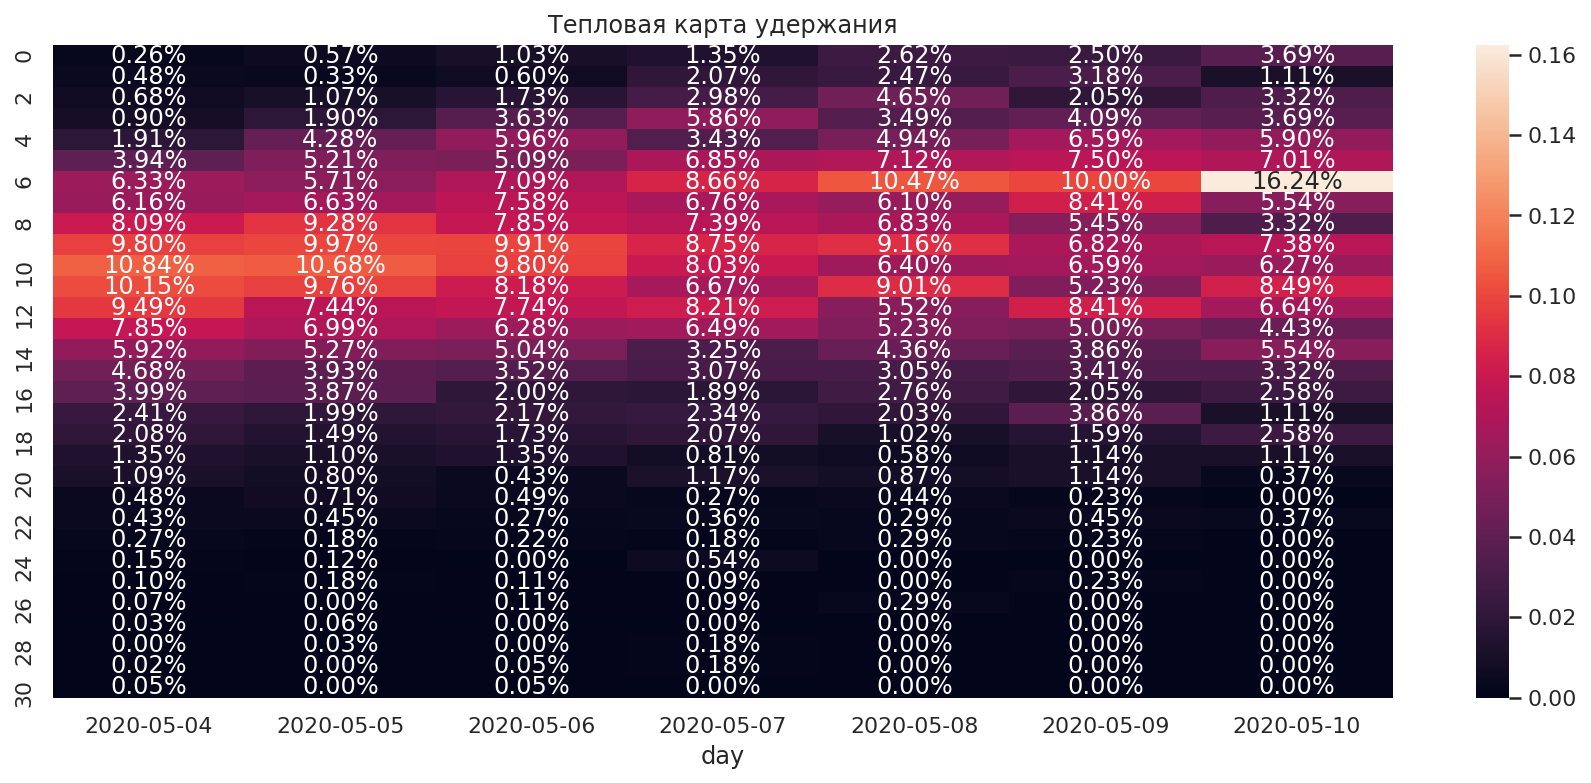

In [66]:
# строим хитмэп

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    retention_raw,  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

Появилась интересная картинка, мы видим, что 16% игроков, присоеденившиеся к игре 10 мая играют в игру 6 дней. 8 и 9 мая 10% игроков тоже играют по 6 дней. А в начале исследуемого периода большая часть игроков играют по 9-11 дней

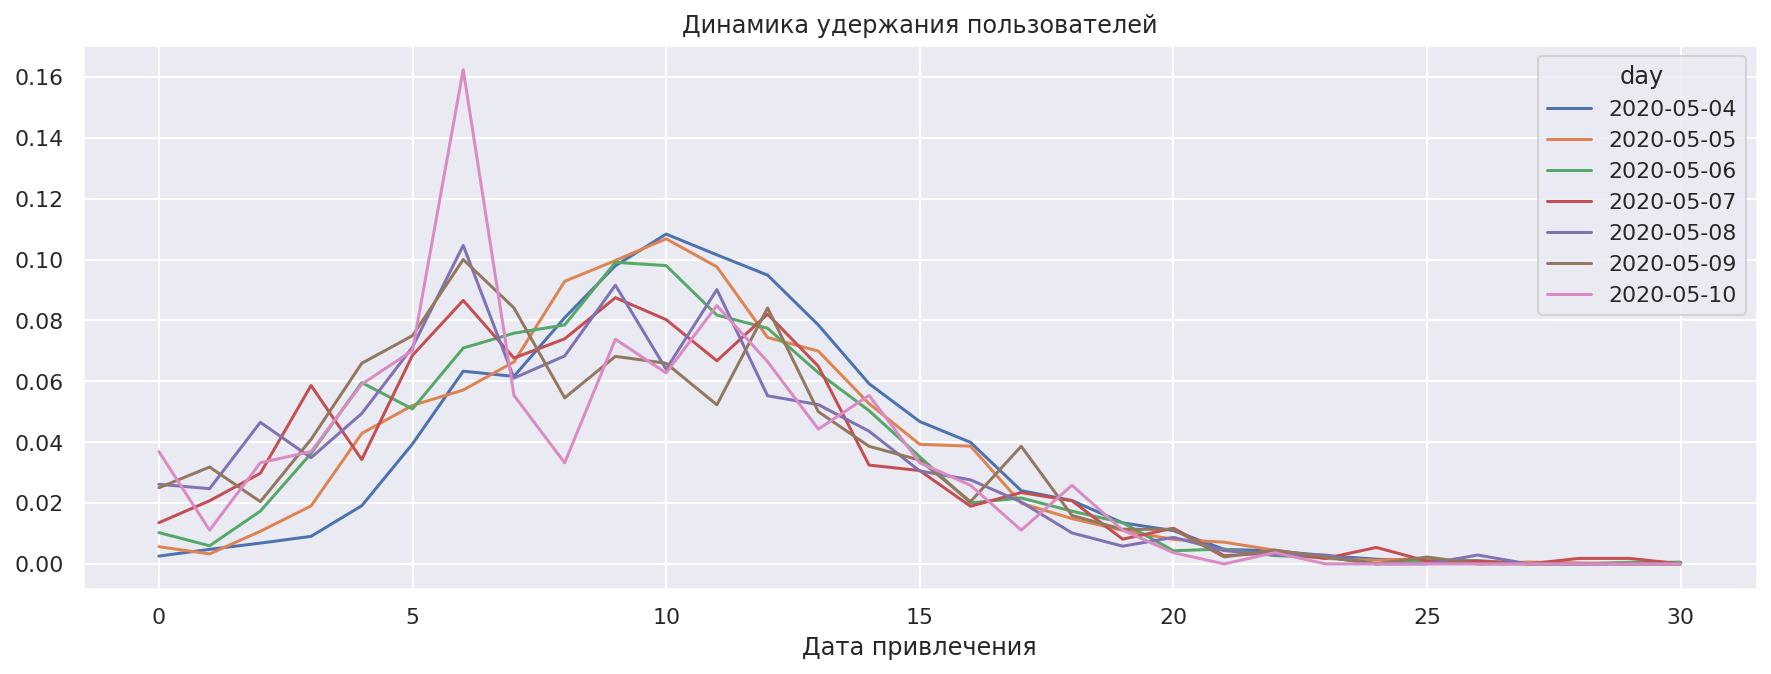

In [67]:
# строим графики изменений

report = retention_raw

report.plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()

По динамике удержания можно отметить, что игроки вступившие в игру 10 мая, в большинстве случаев проводят в игре 6 дней, это может быть связано с тем, что 10 мая - воскресенье, и игрок в свой выходной максимально погрузился в игру для интенсивного прохождения 1 уровня.
Посмотрим теперь хитмап в разрезе источников

In [68]:
# строим таблицу удержания

result_grouped_s = lifetime.pivot_table(
    index=['source'], columns='lifetime', values='user_id', aggfunc='nunique'
)

cohort_sizes_s = (
    lifetime.groupby('source')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)  # вычисляем размеры когорт

result_grouped_s = cohort_sizes_s.merge(
    result_grouped_s, on='source', how='left'
).fillna(0)  # объединяем размеры когорт и таблицу удержания

# делим данные таблицы удержания на размеры когорт
result_grouped_s = result_grouped_s.div(result_grouped_s['cohort_size'], axis=0)


# во время деления все значения cohort_size превратились в единицу
# восстанавливаем — они понадобятся нам позже
result_grouped_s['cohort_size'] = cohort_sizes_s

result_grouped_s.drop(columns=['cohort_size']).T

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
0,0.01,0.01,0.01,0.01
1,0.00,0.01,0.01,0.01
2,0.02,0.01,0.01,0.02
3,0.02,0.02,0.02,0.02
4,0.03,0.04,0.03,0.04
5,0.06,0.04,0.05,0.05
6,0.08,0.06,0.07,0.07
7,0.06,0.07,0.07,0.07
8,0.08,0.08,0.08,0.08
9,0.09,0.10,0.10,0.09


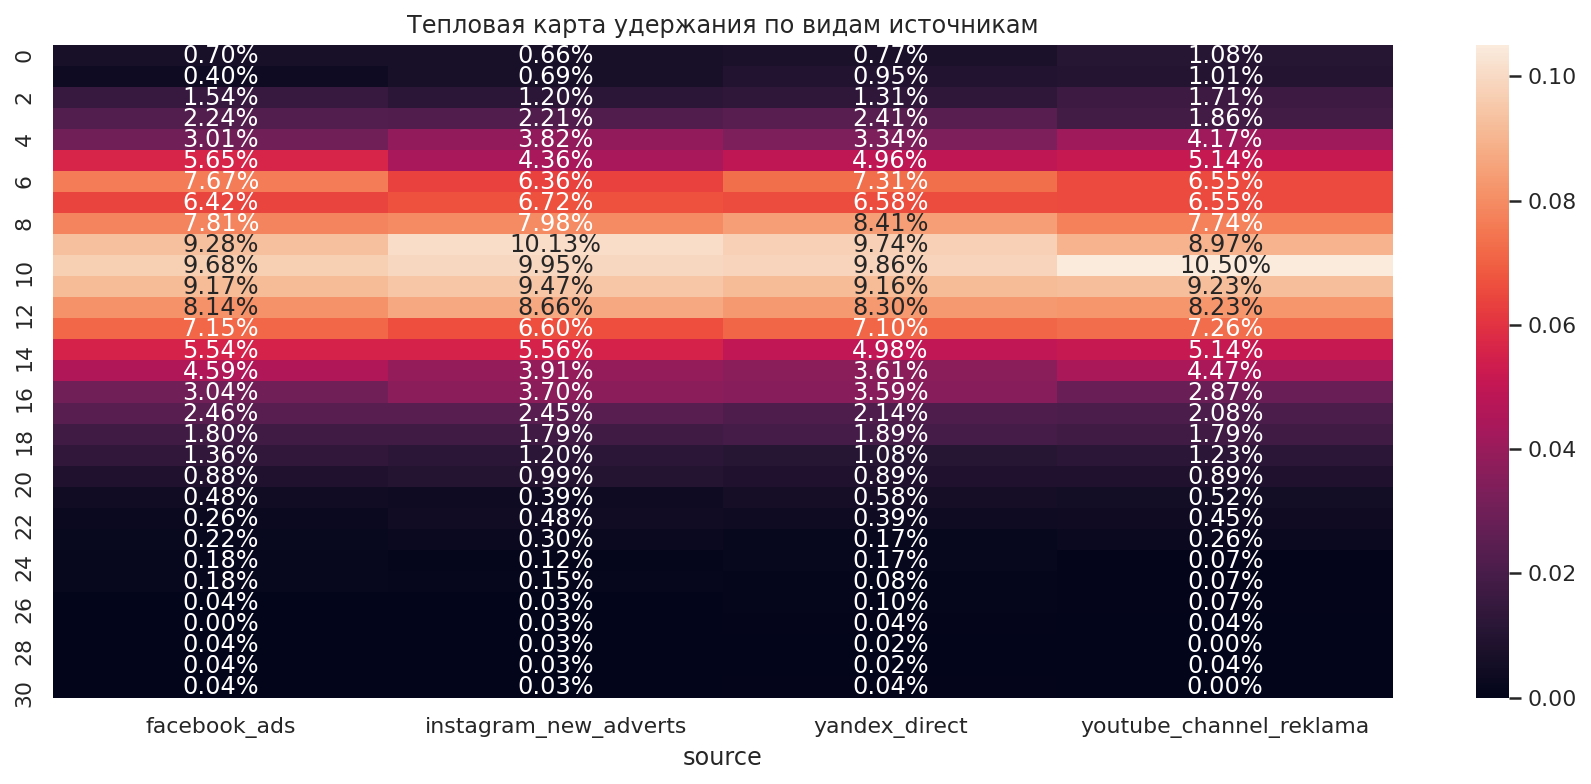

In [69]:
# строим хитмэп

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    result_grouped_s.drop(columns=['cohort_size']).T,  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания по видам источникам')  # название графика
plt.show()

### Вывод
    Появилась интересная картинка, мы видим, что 16% игроков, присоеденившиеся к игре 10 мая играют в игру 6 дней. 8 и 9 мая 10% игроков тоже играют по 6 дней. А в начале исследуемого периода большая часть игроков играют по 9-11 дней
    По динамике удержания можно отметить, что игроки вступившие в игру 10 мая, в большинстве случаев проводят в игре 6 дней, это может быть связано с тем, что 10 мая - воскресенье, и игрок в свой выходной максимально погрузился в игру для интенсивного прохождения 1 уровня. Посмотрим теперь хитмап в разрезе источников
    На последнем графике видна тенденция игры в 9-11 сдей, особенно ярко выраженая у канала YouTube

## Категоризация игроков

Посмотрим какое количесво игроков прошли первый уровень и из какого источника они пришли

В таблицу добавлены категории F - закончил 1 уровень и U - не закончил, колонка cat

PVP - заончил через победу над игроком, PVE - через проект, N не закончил, колонка finish

In [70]:
# игроки, прошедшие первый уровень
finish_users = actions_s[actions_s['event'] != 'building']
finish_users = finish_users.drop(columns = ['building_type','project_type', 'event_datetime', 'day', 'time'], axis = 1)
finish_users = finish_users.drop_duplicates(subset = ['user_id']).reset_index(drop = True)
finish_users.insert(1, "cat", "F")
finish_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5817 entries, 0 to 5816
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   event    5817 non-null   object
 1   cat      5817 non-null   object
 2   user_id  5817 non-null   object
 3   source   5817 non-null   object
dtypes: object(4)
memory usage: 181.9+ KB


In [71]:
# игроки не прошедшие первый уровень
unfinish_users = actions_s[actions_s['event'] == 'building']
unfinish_users = unfinish_users.drop(columns = ['building_type','project_type', 'event_datetime', 'day', 'time'], axis = 1)
unfinish_users = unfinish_users.drop_duplicates(subset = ['user_id']).reset_index(drop = True)
unfinish_users.insert(1, "cat", "U")
unfinish_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   event    13576 non-null  object
 1   cat      13576 non-null  object
 2   user_id  13576 non-null  object
 3   source   13576 non-null  object
dtypes: object(4)
memory usage: 424.4+ KB


In [72]:
all_users = pd.concat([finish_users,unfinish_users])
all_users['user_id'].value_counts().count()
# удалим дублирующихс игроков
all_users = all_users.drop_duplicates(subset = ['user_id'])
all_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13576 entries, 0 to 13575
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   event    13576 non-null  object
 1   cat      13576 non-null  object
 2   user_id  13576 non-null  object
 3   source   13576 non-null  object
dtypes: object(4)
memory usage: 530.3+ KB


In [73]:
all_users_gr = (all_users.groupby('cat')
               .agg({'user_id':'count'})).reset_index()
all_users_gr['%'] = (all_users_gr['user_id']/users_count*100).round(2)

all_users_gr

,cat,user_id,%
0,F,5817,42.85
1,U,7759,57.15


Пришло время посмотреть категории по истоничкам:

In [74]:
all_users_s = pd.pivot_table(all_users,
                            index = 'cat',
                            columns = 'source',
                            values = 'user_id',
                            aggfunc = {'user_id':'count'}).T.reset_index()
all_users_s['%F'] = (all_users_s['F']/users_count*100).round(2)
all_users_s['%U'] = (all_users_s['U']/users_count*100).round(2)
all_users_s['%Total'] = ((all_users_s['U'] + all_users_s['F']) /users_count*100).round(2)
all_users_s

cat,source,F,U,%F,%U,%Total
0,facebook_ads,1150,1576,8.47,11.61,20.08
1,instagram_new_adverts,1466,1881,10.80,13.86,24.65
2,yandex_direct,2042,2775,15.04,20.44,35.48
3,youtube_channel_reklama,1159,1527,8.54,11.25,19.78


In [75]:
all_users.head()

,event,cat,user_id,source
0,project,F,c07b1c10-f477-44dc-81dc-ec82254b1347,facebook_ads
1,finished_stage_1,F,6edd42cc-e753-4ff6-a947-2107cd560710,instagram_new_adverts
2,finished_stage_1,F,cdc6bb92-0ccb-4490-9866-ef142f09139d,yandex_direct
3,finished_stage_1,F,4fe0f101-694b-4e31-9740-d1d87f7208ea,facebook_ads
4,project,F,65a92713-5969-48b1-8945-bfefa5063887,yandex_direct


In [76]:
def finish(row):
    if row ['event'] == 'project':
        return 'PVE'
    if row ['event'] == 'finished_stage_1':
        return 'PVP'
    return 'N'
        
        
all_users['finish'] = all_users.apply(finish, axis = 1)

In [77]:
all_users.head()

,event,cat,user_id,source,finish
0,project,F,c07b1c10-f477-44dc-81dc-ec82254b1347,facebook_ads,PVE
1,finished_stage_1,F,6edd42cc-e753-4ff6-a947-2107cd560710,instagram_new_adverts,PVP
2,finished_stage_1,F,cdc6bb92-0ccb-4490-9866-ef142f09139d,yandex_direct,PVP
3,finished_stage_1,F,4fe0f101-694b-4e31-9740-d1d87f7208ea,facebook_ads,PVP
4,project,F,65a92713-5969-48b1-8945-bfefa5063887,yandex_direct,PVE


In [78]:
all_users = all_users.merge(lifetime, on=['user_id', 'source'], how='outer' )
all_users.head()

,event,cat,user_id,source,finish,first_time,last_time,lifetime,day
0,project,F,c07b1c10-f477-44dc-81dc-ec82254b1347,facebook_ads,PVE,2020-05-04 00:00:03,2020-05-15 05:29:13,11,2020-05-04
1,finished_stage_1,F,6edd42cc-e753-4ff6-a947-2107cd560710,instagram_new_adverts,PVP,2020-05-04 00:00:16,2020-05-16 11:51:58,12,2020-05-04
2,finished_stage_1,F,cdc6bb92-0ccb-4490-9866-ef142f09139d,yandex_direct,PVP,2020-05-04 00:00:35,2020-05-11 14:18:05,7,2020-05-04
3,finished_stage_1,F,4fe0f101-694b-4e31-9740-d1d87f7208ea,facebook_ads,PVP,2020-05-04 00:00:36,2020-05-16 13:08:11,12,2020-05-04
4,project,F,65a92713-5969-48b1-8945-bfefa5063887,yandex_direct,PVE,2020-05-04 00:00:44,2020-05-18 03:50:27,14,2020-05-04


In [79]:
all_users['day_n'] = all_users['first_time'].dt.weekday
all_users.head()

,event,cat,user_id,source,finish,first_time,last_time,lifetime,day,day_n
0,project,F,c07b1c10-f477-44dc-81dc-ec82254b1347,facebook_ads,PVE,2020-05-04 00:00:03,2020-05-15 05:29:13,11,2020-05-04,0
1,finished_stage_1,F,6edd42cc-e753-4ff6-a947-2107cd560710,instagram_new_adverts,PVP,2020-05-04 00:00:16,2020-05-16 11:51:58,12,2020-05-04,0
2,finished_stage_1,F,cdc6bb92-0ccb-4490-9866-ef142f09139d,yandex_direct,PVP,2020-05-04 00:00:35,2020-05-11 14:18:05,7,2020-05-04,0
3,finished_stage_1,F,4fe0f101-694b-4e31-9740-d1d87f7208ea,facebook_ads,PVP,2020-05-04 00:00:36,2020-05-16 13:08:11,12,2020-05-04,0
4,project,F,65a92713-5969-48b1-8945-bfefa5063887,yandex_direct,PVE,2020-05-04 00:00:44,2020-05-18 03:50:27,14,2020-05-04,0


In [80]:
#Стоимость прихода пользователей
# сначал я создам сводную таблицу сколько в какой день пришло пользователей
for_costs_u = pd.pivot_table(all_users, 
                             index = 'day', 
                             columns = 'source', 
                             values = 'user_id',  
                             aggfunc = {'user_id':'count'})
for_costs_u

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
day,,,,
2020-05-04,1184,1452,2078,1146
2020-05-05,694,796,1208,663
2020-05-06,345,472,664,366
2020-05-07,224,270,395,220
2020-05-08,139,175,239,135
2020-05-09,84,112,144,100
2020-05-10,56,70,89,56


In [81]:
# потом в какой день какой источник потратил денег
for_costs_c = pd.pivot_table(costs,
                             index = 'day',
                             columns = 'source',
                             values = 'cost',
                             aggfunc = {'cost':'sum'})
for_costs_c

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
day,,,,
2020-05-04,935.88,943.20,969.14,454.22
2020-05-05,548.35,502.93,554.65,259.07
2020-05-06,260.19,313.97,308.23,147.04
2020-05-07,177.98,173.07,180.92,88.51
2020-05-08,111.77,109.92,114.43,55.74
2020-05-09,68.01,71.58,62.96,40.22
2020-05-10,38.72,46.78,42.78,23.31


In [82]:
# считаем в какой день из какого источника стоило привлечение
a = np.array(for_costs_c)
b = np.array(for_costs_u)
c = a / b
c

array([[0.79044154, 0.64959003, 0.46638084, 0.39635684],
       [0.79013614, 0.63181589, 0.45914859, 0.39075901],
       [0.75416161, 0.66519276, 0.46420631, 0.40175339],
       [0.79456339, 0.64100424, 0.45801797, 0.40230034],
       [0.80407767, 0.62808717, 0.47878384, 0.41289366],
       [0.80963424, 0.63909589, 0.43723354, 0.40217907],
       [0.6914884 , 0.66822   , 0.48066859, 0.41633338]])

In [83]:
# напишем функцию, чтобы заполнить какой пользователь в какой день сколько стоил 
#(извините за такую уродскую функцию - несмогла справиться с циклом)
def cost(row):
    if row['source'] == 'facebook_ads' and row['day_n'] == 0:
        return c[0][0]
    if row['source'] == 'facebook_ads' and row['day_n'] == 1:
        return c[1][0]
    if row['source'] == 'facebook_ads' and row['day_n'] == 2:
        return c[2][0]
    if row['source'] == 'facebook_ads' and row['day_n'] == 3:
        return c[3][0]
    if row['source'] == 'facebook_ads' and row['day_n'] == 4:
        return c[4][0]
    if row['source'] == 'facebook_ads' and row['day_n'] == 5:
        return c[5][0]
    if row['source'] == 'facebook_ads' and row['day_n'] == 6:
        return c[6][0]
    if row['source'] == 'instagram_new_adverts' and row['day_n'] == 0:
        return c[0][1]
    if row['source'] == 'instagram_new_adverts' and row['day_n'] == 1:
        return c[1][1]
    if row['source'] == 'instagram_new_adverts' and row['day_n'] == 2:
        return c[2][1]
    if row['source'] == 'instagram_new_adverts' and row['day_n'] == 3:
        return c[3][1]
    if row['source'] == 'instagram_new_adverts' and row['day_n'] == 4:
        return c[4][1]
    if row['source'] == 'instagram_new_adverts' and row['day_n'] == 5:
        return c[5][1]
    if row['source'] == 'instagram_new_adverts' and row['day_n'] == 6:    
        return c[6][1]
    if row['source'] == 'yandex_direct' and row['day_n'] == 0:
        return c[0][2]
    if row['source'] == 'yandex_direct' and row['day_n'] == 1:
        return c[1][2]
    if row['source'] == 'yandex_direct' and row['day_n'] == 2:
        return c[2][2]
    if row['source'] == 'yandex_direct' and row['day_n'] == 3:
        return c[3][2]
    if row['source'] == 'yandex_direct' and row['day_n'] == 4:
        return c[4][2]
    if row['source'] == 'yandex_direct' and row['day_n'] == 5:
        return c[5][2]
    if row['source'] == 'yandex_direct' and row['day_n'] == 6:   
        return c[6][2]
    if row['source'] == 'youtube_channel_reklama' and row['day_n'] == 0:
        return c[0][3]
    if row['source'] == 'youtube_channel_reklama' and row['day_n'] == 1:
        return c[1][3]
    if row['source'] == 'youtube_channel_reklama' and row['day_n'] == 2:
        return c[2][3]
    if row['source'] == 'youtube_channel_reklama' and row['day_n'] == 3:
        return c[3][3]
    if row['source'] == 'youtube_channel_reklama' and row['day_n'] == 4:
        return c[4][3]
    if row['source'] == 'youtube_channel_reklama' and row['day_n'] == 5:
        return c[5][3]
    if row['source'] == 'youtube_channel_reklama' and row['day_n'] == 6:   
        return c[6][3]

In [84]:
all_users['costs'] = all_users.apply(cost, axis = 1)
all_users.head()

,event,cat,user_id,source,finish,first_time,last_time,lifetime,day,day_n,costs
0,project,F,c07b1c10-f477-44dc-81dc-ec82254b1347,facebook_ads,PVE,2020-05-04 00:00:03,2020-05-15 05:29:13,11,2020-05-04,0,0.79
1,finished_stage_1,F,6edd42cc-e753-4ff6-a947-2107cd560710,instagram_new_adverts,PVP,2020-05-04 00:00:16,2020-05-16 11:51:58,12,2020-05-04,0,0.65
2,finished_stage_1,F,cdc6bb92-0ccb-4490-9866-ef142f09139d,yandex_direct,PVP,2020-05-04 00:00:35,2020-05-11 14:18:05,7,2020-05-04,0,0.47
3,finished_stage_1,F,4fe0f101-694b-4e31-9740-d1d87f7208ea,facebook_ads,PVP,2020-05-04 00:00:36,2020-05-16 13:08:11,12,2020-05-04,0,0.79
4,project,F,65a92713-5969-48b1-8945-bfefa5063887,yandex_direct,PVE,2020-05-04 00:00:44,2020-05-18 03:50:27,14,2020-05-04,0,0.47


In [85]:
# посчитаю сколько столило привести одного игрока из разных каналов
costs_user_per_sours = pd.pivot_table(all_users, index = 'source',
                                      columns = 'cat',
                                      values = 'costs',
                                      aggfunc = {'costs':'sum'}).reset_index()
costs_user_per_sours['cost_one_F'] = costs_user_per_sours['F']/all_users_s['F']
costs_user_per_sours['cost_one_U'] = costs_user_per_sours['U']/all_users_s['U']
costs_user_per_sours

cat,source,F,U,cost_one_F,cost_one_U
0,facebook_ads,904.24,1236.67,0.79,0.78
1,instagram_new_adverts,946.74,1214.70,0.65,0.65
2,yandex_direct,946.89,1286.22,0.46,0.46
3,youtube_channel_reklama,460.13,607.99,0.40,0.40


In [86]:
# посчитаю сколько столило привести одного игрока в каждый день привлечения
users_per_day = pd.pivot_table(all_users, 
                                    index = 'day', 
                                    columns = 'cat', 
                                    values = 'user_id', 
                                    aggfunc = {'user_id':'count'}).reset_index()
users_per_day

cat,day,F,U
0,2020-05-04,2670,3190
1,2020-05-05,1513,1848
2,2020-05-06,771,1076
3,2020-05-07,412,697
4,2020-05-08,235,453
5,2020-05-09,134,306
6,2020-05-10,82,189


In [87]:
costs_user_per_day = pd.pivot_table(all_users, 
                                    index = 'day', 
                                    columns = 'cat', 
                                    values = 'costs', 
                                    aggfunc = {'costs':'sum'}).reset_index()

costs_user_per_day['cost_F'] = costs_user_per_day['F']/users_per_day['F']
costs_user_per_day['cost_U'] = costs_user_per_day['U']/users_per_day['U']
costs_user_per_day

cat,day,F,U,cost_F,cost_U
0,2020-05-04,1503.69,1798.76,0.56,0.56
1,2020-05-05,841.40,1023.61,0.56,0.55
2,2020-05-06,427.47,601.96,0.55,0.56
3,2020-05-07,228.98,391.50,0.56,0.56
4,2020-05-08,135.32,256.54,0.58,0.57
5,2020-05-09,75.24,167.53,0.56,0.55
6,2020-05-10,45.90,105.69,0.56,0.56


### Вывод

Я разеделила пользователей, кто прошел и не прошел 1 уровень и разделила их по источникам привлечения:

    к игре присоеденились 13576 игроков в период с 4 по 10 мая
    почти 47% прошли первый уровень, 53% соответсвенно где-то застряли;
    35% от всех игроков пришли из канала яндекс.директ
    20% от всех пользователей не прошли первый уровень и пришли из я.д.
    самым дешевым по прислечению игроков, который закончили перывй уровень стал youtube 0.40, самым дорогим стал фэйсбук - 0.79 
    
        

## Проверка статистических гипотез

Проверю гипотезу: время завершения уровня различается в зависимости способа прохождения:

    Н0 время завершения уровня быстрее через реализацию проекта
    Н1 время завершения уровня быстрее через победу над первым игроком

раздем победивших на две группы:

    кто завершил первым событие `finished_stage_1
    кто зевершил первым событие `project`

In [88]:
# Проверим гипотезу, что 1. *время завершения уровня различается в зависимости способа прохождения: pvv или pve
all_users.groupby('finish')['lifetime'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
finish,,,,,,,,
N,7759.00,9.29,4.35,0.00,6.00,9.00,12.00,29.00
PVE,1866.00,12.96,3.53,5.00,10.00,13.00,15.00,29.00
PVP,3951.00,10.61,4.11,0.00,8.00,10.00,13.00,30.00


Исходя из показателей медианы, среднего и стандартного отклонения прохождение PVP или PVE можно предположить, что среднее прохождение первых 10.6 дней, отличается от среднего прохождения вторых почти 13 дней. Проверим это методами статистического анализа

Чтобы проверить гипотезу о различии среднего прохождения уровня двумя разными способами PVP и PVE, применим метод scipy.stats.ttest_ind(). Данный метод применяется к двум независимым совокупностям, а наши игроки PVP и PVE составляют независимые совокупности, так как это разные люди, поведение которых не зависит друг от друга.

Зададим критический уровень статистической значимости alpha равным 5% и проверим нулевую гипотезу

In [89]:
alpha = .05
results = st.ttest_ind(all_users.query('finish== "PVP"')['lifetime'], all_users.query('finish== "PVE"')['lifetime'])
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.8882835392369192e-97
Отвергаем нулевую гипотезу


p-значение: 1.88 - не очень большое, но все же нулевую гипотезу отвергаем!

Приверие еще одну:



Н0 - стоимость игрока категории "а"(F) выше, чем стоимость тгрока категории "б"(U)

Н1 - стоимоть игрока "а" не выше стоимости игрока категории "б"

In [90]:
all_users.groupby('cat')['costs'].describe()

,count,mean,std,min,25%,50%,75%,max
cat,,,,,,,,
F,5817.00,0.56,0.14,0.39,0.46,0.47,0.65,0.81
U,7759.00,0.56,0.14,0.39,0.46,0.47,0.65,0.81


тут получилось очень странно, почему-то показатели одинаковые, для проверки двусторонней гипотезы проведем t-тест. Учитывая, что в тесте принимают участие две независимые друг от друга совокупности, равность которых нужно проверить, для проверки гипотезы необходимо использовать метод _scipy.stats.ttestind:

In [91]:
alpha = .05
results = st.ttest_ind(all_users.query('cat== "F"')['costs'], all_users.query('cat== "U"')['costs'])
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9956728889757203
Не получилось отвергнуть нулевую гипотезу


Не смотря на то, то оценки центрального положения все одинаковые, игроки категории F немного ыше чем игроки категории U

### Вывод
    Пользователей в игре: 13576
    Количество событий: 135639 событий
    Пик совершенных событий приходится на 10 мая 2020 года (15207 событий);
    Пик пользователей приходится на 10 мая 2020 года (9219 человек);
    После 10 мая 2020 года активность пользователей в игре стремительно снижается.
    Самое популярное событие в игре building (около 94% всех событий в игре);
    Реализация проекта занимает всего 1% всех событий в игре;
    Больше всего событий, косающихся завершения 1 уровня, приходится на 16 мая 2020 года;
    Самое популярное здание в игре spaceport (около 46% из всех построенных зданий в игре);
    Всего первый уровень завершили 5817 (42.8%) игроков;
    1866 (13.7%) пользователей завершили уровень через реализацию проекта;
    3951 (29.1%) пользователей завершили уровень победой над первым врагом;
    Самый популярный рекламный источник - Yandex.Direct, именно через него в игру пришло 4817 (35.48%) пользователей;
    Наименее популярные источники: Facebook (20.08% пользователей) и Youtube (19.78% пользователей);
    Всего за период проведения рекламной компании было затрачено 7604 у.е.;
    43% всех рекламных затрат произведено 3 мая 2020 года (в первый день рекламной компании);
    Самое большое количество затрат (29.37%) ушло на рекламный источник Yandex.Direct;
    Наименьшие затраты (14.05%) на рекламный источник Youtube;
    В течении рекламной компании затраты на все источники равномерно снижаются;
    Среднее количество событий на пользователя: 10.0
    Медианное количество событий на пользователя: 10.0
    
      Пик пользователей в разрезе источников наблюдается 10 мая 2020 года, после чего наблюдается спад;
    Больше всего зданий (45032 события) построено пользователями, пришедшими через рекламный источник Yandex.Direct;
    Максимальное количество пользователей, завершивших первый уровень (2042 пользователя), пришло через рекламный источник Yandex.Direct;
    Максимальное количество пользователей, завершивших первый уровень реализацией проекта (620 пользователей), пришло через рекламный источник Yandex.Direct;
    Больше всего зданий различного типа построено пользователями, пришедшими через рекламный источник Yandex.Direct;
    В среднем пользователи проводят в игре около 11-12 дней, независимо от источника перехода;
    В среднем пользователям требуется около 12-13 дней на завершение 1 уровня, независимо от источника перехода;
    
    В среднем пользователи проводят в игре около 11-12 дней, независимо от источника перехода;
    В среднем пользователям требуется около 12-13 дней на завершение 1 уровня;
    Количество построек влияет на время нахождения в игре (большек построек - больше проведенного в игре времени);
    
     Появилась интересная картинка, мы видим, что 16% игроков, присоеденившиеся к игре 10 мая играют в игру 6 дней. 8 и 9 мая 10% игроков тоже играют по 6 дней. А в начале исследуемого периода большая часть игроков играют по 9-11 дней
    По динамике удержания можно отметить, что игроки вступившие в игру 10 мая, в большинстве случаев проводят в игре 6 дней, это может быть связано с тем, что 10 мая - воскресенье, и игрок в свой выходной максимально погрузился в игру для интенсивного прохождения 1 уровня. Посмотрим теперь хитмап в разрезе источников
    На последнем графике видна тенденция игры в 9-11 сдей, особенно ярко выраженая у канала YouTube
    
    Была отвергнута нулевая гипотеза, что время завершения уровня быстрее через реализацию проекта
    И еще одну гипотезу отвернуть не получилось: стоимость игрока категории "а"(F) выше, чем стоимость тгрока категории "б"(U)
    Самыми перспективными каналами перехода являются Яндекс.Директ (самый популярный), и Ютуб (самый дешовый)


Даш-борд: https://public.tableau.com/app/profile/anna.glagoleva/viz/_16603156375540/Dashboard1?publish=yes

презентация: https://drive.google.com/file/d/1YKFCYrCvEv2VpTd2A8Q0cZuKtalCX6M4/view?usp=sharing